# Data Analytics - ISIS Twitter's fans - Network Analysis

Autori
- **Volpato Mattia 866316**
- **Preziosa Alessandro 866142**

Obiettivi:
- Esplorazione del **dataset**
- Costruzione del **grafo delle citazioni tra utenti**
- Costruzione del **grafo delle citazioni a entità**
- Estrazione di un **ranking** delle **entità più importanti**
- Confronto tra **entità** e **hashtags**
- Analisi della relazione tra **importanza** e **sentiment** legati a un'**entità**


## Installazione delle dipendenze

In [1]:
!pip install igraph
!pip install cairocffi
!pip install googletrans==4.0.0-rc1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 962.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 915.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 979.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.4 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17395 sha256=a68bb02d43979f762e93b184f635ffc93bd55cedded04f2ba7940dc64d4c7969
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe

## Importazione delle librerie

In [2]:
import igraph as ig
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
from datetime import datetime, time as tm

from tqdm import tqdm
from collections import Counter

from collections import Counter

from googletrans import Translator

import ast
import pickle

## Importazione ed esplorazione del Dataset

### Importazione

In [3]:
df = pd.read_csv("tweets.csv")

print("Dimension:", df.shape)
df.head()

Dimension: (17410, 8)


,name,username,description,location,followers,numberstatuses,time,tweets
0,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:07,ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...
1,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:27,ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...
2,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:29,ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...
3,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:37,ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...
4,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,640,49,1/6/2015 21:45,ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...


### Esplorazione del dataset

In [4]:
grouped_df = df.groupby('username')
rappr = {}

for group_name, group_data in grouped_df:
  rappr[group_name] = {'followers': round(group_data['followers'].mean()),
                       'numberstatuses': round(group_data['numberstatuses'].mean())
                       }

for index, record in df.iterrows():
  df.at[index, 'followers'] = rappr[record['username']]['followers']
  df.at[index, 'numberstatuses'] = rappr[record['username']]['numberstatuses']

df

,name,username,description,location,followers,numberstatuses,time,tweets
0,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,639,49,1/6/2015 21:07,ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...
1,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,639,49,1/6/2015 21:27,ENGLISH TRANSLATION: SHEIKH FATIH AL JAWLANI '...
2,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,639,49,1/6/2015 21:29,ENGLISH TRANSLATION: FIRST AUDIO MEETING WITH ...
3,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,639,49,1/6/2015 21:37,ENGLISH TRANSLATION: SHEIKH NASIR AL WUHAYSHI ...
4,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,639,49,1/6/2015 21:45,ENGLISH TRANSLATION: AQAP: 'RESPONSE TO SHEIKH...
...,...,...,...,...,...,...,...,...
17405,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 15:46,#Breaking\n#IslamicState \n#AmaqAgency \n\n#Fr...
17406,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 15:50,#Breaking\n\n Iraqi forces bulldozer destroyed...
17407,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 15:51,#Breaking \n#AmaqAgency \n#IslamicState \n\n#E...
17408,Anaksabil97,nvor85j,NaN,NaN,238,133,5/13/2016 16:07,#PhotoReport \n#WilayatDimasiqh \n\n📷The Condu...


#### Utenti con più tweets nel dataset

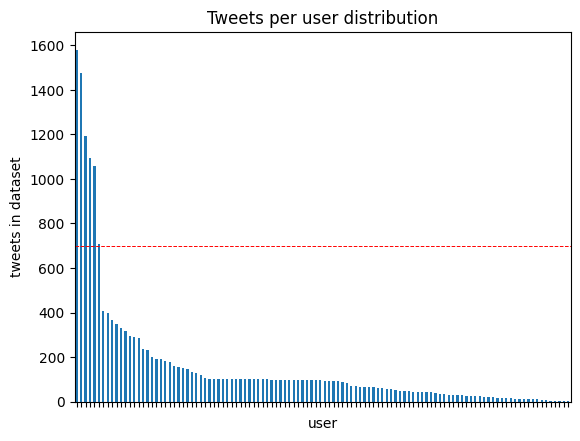

In [5]:
tweets_count = df['username'].value_counts()
ax = tweets_count.plot(kind='bar', xlabel='user', ylabel='tweets in dataset', title='Tweets per user distribution')

ax.axhline(y=700, color='red', linestyle='--', linewidth=0.7, label='y=700')
ax.set_xticklabels([])
ax.legend().set_visible(False)

plt.show()

In [6]:
tweets_count[tweets_count.values > 600]

username
Uncle_SamCoco    1580
RamiAlLolah      1475
warrnews         1191
WarReporter1     1095
mobi_ayubi       1056
_IshfaqAhmad      709
Name: count, dtype: int64

In [7]:
user = 'MaghrebiQM'
print(tweets_count[user] / len(df), tweets_count[user])
df[df['username'] == user]

0.009075244112578977 158


,name,username,description,location,followers,numberstatuses,time,tweets
2188,Maghrebi,MaghrebiQM,A Moroccan engineer in nanotechnology commenti...,NaN,1559,343,1/31/2016 11:48,RT @deSyracuse: #Latakia - Loyalist forces con...
2189,Maghrebi,MaghrebiQM,A Moroccan engineer in nanotechnology commenti...,NaN,1559,343,1/31/2016 11:48,"""De Mistura is meeting with the Syrian Opposit..."
2190,Maghrebi,MaghrebiQM,A Moroccan engineer in nanotechnology commenti...,NaN,1559,343,1/31/2016 11:49,"""30 killed, 40 injured after a bombing in ""Say..."
2191,Maghrebi,MaghrebiQM,A Moroccan engineer in nanotechnology commenti...,NaN,1559,343,1/31/2016 11:50,#IS has claimed responsibility via #AmaqNewsAg...
2192,Maghrebi,MaghrebiQM,A Moroccan engineer in nanotechnology commenti...,NaN,1559,343,1/31/2016 11:51,@abuabbas5 الغباء فيكم والله لم أرى مثله
...,...,...,...,...,...,...,...,...
3411,Maghrebi,MaghrebiQM,A Moroccan engineer in nanotechnology commenti...,NaN,1559,343,2/6/2016 12:03,@DrPartizan_ Can you please use the regular na...
3412,Maghrebi,MaghrebiQM,A Moroccan engineer in nanotechnology commenti...,NaN,1559,343,2/6/2016 12:04,@DrPartizan_ Thank you :)
3413,Maghrebi,MaghrebiQM,A Moroccan engineer in nanotechnology commenti...,NaN,1559,343,2/6/2016 12:13,"@EwanIsmael No need to get excited, it's just ..."
3417,Maghrebi,MaghrebiQM,A Moroccan engineer in nanotechnology commenti...,NaN,1559,343,2/6/2016 12:51,RT @intlspectator: BREAKING: Turkey says it ha...


In [8]:
sum(tweets_count[tweets_count.values > 600].values) / len(df)

0.4081562320505457

#### Followers

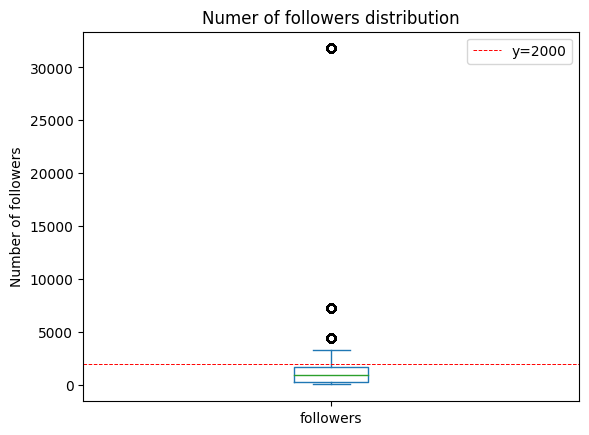

In [9]:
ax = df['followers'].plot(kind='box')

ax.axhline(y=2000, color='red', linestyle='--', linewidth=0.7, label='y=2000')

plt.legend()
plt.title("Numer of followers distribution")
plt.ylabel("Number of followers")
plt.show()

#### Numero di tweets totale per utente

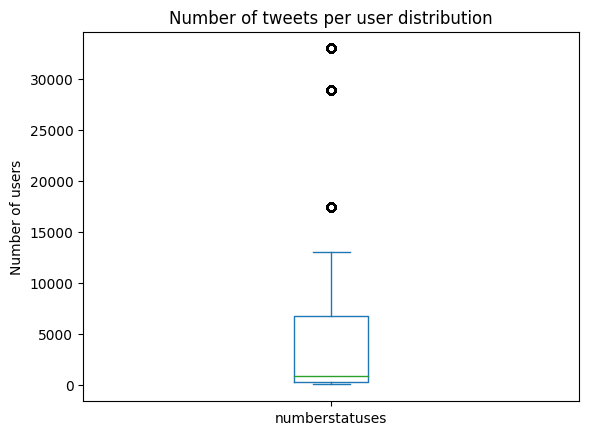

In [10]:
df['numberstatuses'].plot(kind='box')

plt.title("Number of tweets per user distribution")
plt.ylabel("Number of users")
plt.show()

#### Orario dei tweets

Funzione per **discretizzare** l'ora di un **tweet**:
- Tra 00:00 e 05:59 : **night**
- Tra 06:00 e 11:59 : **morning**
- Tra 12:00 e 17:59 : **afternoon**
- Tra 18:00 e 23:59 : **evening**

In [11]:
def categorize_day_time(date_and_time:str):
  if isinstance(date_and_time, int):
    time = tm(date_and_time)
  else:
    try:
      time = datetime.strptime(date_and_time, '%m/%d/%Y %H:%M').time()
    except Exception as e:
      return 'other'

  categorization = [(tm(0, 0), "night"),
                    (tm(6, 0), "morning"),
                    (tm(12, 0), "afternoon"),
                    (tm(18, 0), "evening")]

  for i in range(len(categorization) - 1):
    if categorization[i][0] <= time < categorization[i + 1][0]:
      return categorization[i][1]

  return categorization[-1][1]

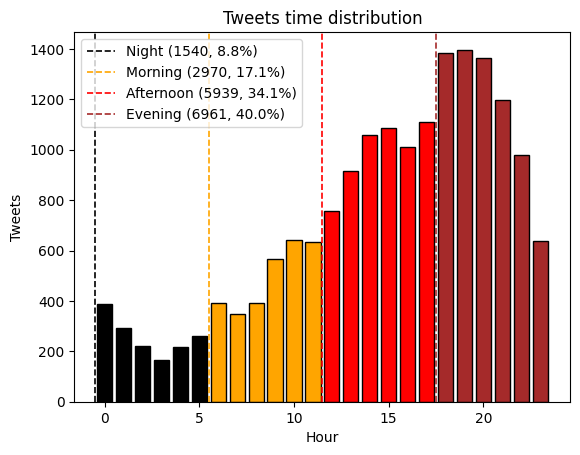

In [12]:
tweet_day_time = Counter()
tweet_times = {}

for index, record in df.iterrows():
  tweet_time = datetime.strptime(record['time'], '%m/%d/%Y %H:%M').time().hour
  tweet_times[tweet_time] = tweet_times.get(tweet_time, 0) + 1

  tweet_day_time[categorize_day_time(record['time'])] += 1


colors = []
for time in tweet_times:
  day_time = categorize_day_time(time)
  if day_time == 'night':
    colors.append('black')
  elif day_time == 'morning':
    colors.append('orange')
  elif day_time == 'afternoon':
    colors.append('red')
  elif day_time == 'evening':
    colors.append('brown')

tot_tweets = sum(tweet_day_time.values())

plt.bar(tweet_times.keys(), tweet_times.values(), edgecolor='black', color=colors)
plt.axvline(x=-0.5, color='black', linestyle='--', linewidth=1.2, label=f"Night ({tweet_day_time['night']}, {tweet_day_time['night'] / tot_tweets * 100:.1f}%)")
plt.axvline(x=5.5, color='orange', linestyle='--', linewidth=1.2, label=f"Morning ({tweet_day_time['morning']}, {tweet_day_time['morning'] / tot_tweets * 100:.1f}%)")
plt.axvline(x=11.5, color='red', linestyle='--', linewidth=1.2, label=f"Afternoon ({tweet_day_time['afternoon']}, {tweet_day_time['afternoon'] / tot_tweets * 100:.1f}%)")
plt.axvline(x=17.5, color='brown', linestyle='--', linewidth=1.2, label=f"Evening ({tweet_day_time['evening']}, {tweet_day_time['evening'] / tot_tweets * 100:.1f}%)")

plt.title("Tweets time distribution")
plt.xlabel("Hour")
plt.ylabel("Tweets")
plt.legend(loc='upper left')

plt.show()

#### Luoghi dei tweets

In [13]:
df['location'].value_counts()

location
Read my blog                                     1475
world                                            1191
Worldwide contributions                           998
Texas, USA                                        993
اُمتِ مُسلمہ ولایت کشمیر                          709
United States                                     587
28th Street, Qamar Precint                        426
Germany                                           397
Dunya                                             366
Male'. Maldives.                                  333
S.Wazirstan|Mahsud not a Wazir                    318
Middle of Nowhere                                 303
dar al-kufr                                       285
Nowhere                                           234
Wilayah Kashmir                                   231
München, Deutschland                              193
Bandar Seri Begawan, Negara Brunei Darussalam     182
Geneva, Switzerland                               166
Ghurabā            

### Elaborazione del Dataset

In [14]:
CITATIONS_COL_NAME = "citations"
HASHTAGS_COL_NAME = "hashtags"
ENTITIES_COL_NAME = "entities"
N_TWEETS_COL_NAME = "n_tweets"
TWEET_TIME_COL_NAME = "tweets_time"
LOCATION_COL_NAME = "location"

#### Ricerca delle menzioni e degli hashtag

Ricerca delle **citazioni** e degli **hashtags** tramite ***espressioni regolari***

In [15]:
username_pattern = r'\@(\w+)'    # Brackets allows to return only \w+
hashtag_pattern = r'\#(\w+)'

df[CITATIONS_COL_NAME] = None
df[HASHTAGS_COL_NAME] = None

for record_index, record in tqdm(df.iterrows(), total=len(df), desc="Searching for mentions and hashtags"):    # Iterate over (key, value)
  citations = re.findall(username_pattern, record.tweets)
  hashtags = re.findall(hashtag_pattern, record.tweets)
  df.at[record_index, CITATIONS_COL_NAME] = citations
  df.at[record_index, HASHTAGS_COL_NAME] = hashtags

df.shape

Searching for mentions and hashtags: 100%|██████████| 17410/17410 [00:05<00:00, 3096.46it/s]


(17410, 10)

#### Importazione DataFrame **entity-tweet**

In [16]:
entity_tweet_df = pd.read_excel('entity_tweet.xlsx')
entity_tweet_df.columns = ['name', 'entities', 'type', 'sentiment']
entity_tweet_df['entities'] = entity_tweet_df['entities'].apply(lambda x : ast.literal_eval(x) if isinstance(x, str) else x)
entity_tweet_df['type'] = entity_tweet_df['type'].apply(lambda x : ast.literal_eval(x) if isinstance(x, str) else x)

entity_tweet_df

,name,entities,type,sentiment
0,GunsandCoffee,"[syria - sheikh, abu muhammed]","[ORG, ORG]",1.147000
1,GunsandCoffee,"[al jawlani ', the people of integrity]","[PERSON, ORG]",2.051250
2,GunsandCoffee,[al jawlani '],[PERSON],0.000000
3,GunsandCoffee,"[al wuhayshi, leader, aqap, the promise of vic...","[PERSON, ORG, PERSON, WORK_OF_ART]",1.128833
4,GunsandCoffee,[aqap],[PERSON],-1.954500
...,...,...,...,...
17405,Anaksabil97,[amaqagency fridaythe13th dolceamoreforgotten],[PERSON],0.000000
17406,Anaksabil97,"[iraqi, albouhayat, dubnation mufc]","[NORP, LOC, FAC]",-2.734750
17407,Anaksabil97,[],[],0.000000
17408,Anaksabil97,[],[],-1.454500


In [17]:
entity_tweet_dict = {}
for i, record in tqdm(entity_tweet_df.iterrows(), desc='Indexing entities\' types', total=len(entity_tweet_df)):
    for j, entity in enumerate(record['entities']):
        if not entity in entity_tweet_dict:
            entity_tweet_dict[entity] = record['type'][j]
        elif record['type'][j] != entity_tweet_dict[entity]:
             entity_tweet_dict[entity + record['type'][j]] = record['type'][j]

entity_tweet_dict

Indexing entities' types: 100%|██████████| 17410/17410 [00:04<00:00, 3535.05it/s]


{'syria - sheikh': 'ORG',
 'abu muhammed': 'ORG',
 "al jawlani '": 'PERSON',
 'the people of integrity': 'ORG',
 'al wuhayshi': 'PERSON',
 'leader': 'ORG',
 'aqap': 'PERSON',
 "the promise of victory'": 'WORK_OF_ART',
 'clip': 'ORG',
 'oh murabit': 'ORG',
 "u'lama": 'GPE',
 'khalidmaghrebi seifulmaslul123 cheerleadunited': 'ORG',
 'france': 'GPE',
 'halidmaghrebi seyiful': 'PERSON',
 'one': 'CARDINAL',
 "been brightened'": 'PERSON',
 'abu hasan': 'ORG',
 'nabi s.a.w': 'PERSON',
 'abu hasanPERSON': 'PERSON',
 'al kuwaiti': 'PERSON',
 'jn': 'GPE',
 'ibnnabih1 khalidmaghrebi_ muwmedia': 'FAC',
 'inshallah': 'ORG',
 'us knw': 'PERSON',
 'half': 'CARDINAL',
 'a few more days': 'DATE',
 'abdirahmanbash2 khalidmaghrebi': 'PERSON',
 'syrian': 'NORP',
 'tomorrow': 'DATE',
 'jn video - eng subs: the path of salvation :watch': 'ORG',
 'english': 'LANGUAGE',
 'the path of salvation': 'WORK_OF_ART',
 'ansardeenfront': 'GPE',
 'eng': 'PERSON',
 'pamphlet': 'WORK_OF_ART',
 'jn regarding is group of ‘

In [18]:
df['entities'] = entity_tweet_df['entities']
df['sentiment'] = entity_tweet_df['sentiment']
df['entities_category'] = entity_tweet_df['type']
df.head(1)

,name,username,description,location,followers,numberstatuses,time,tweets,citations,hashtags,entities,sentiment,entities_category
0,GunsandCoffee,GunsandCoffee70,ENGLISH TRANSLATIONS: http://t.co/QLdJ0ftews,NaN,639,49,1/6/2015 21:07,ENGLISH TRANSLATION: 'A MESSAGE TO THE TRUTHFU...,[],[],"[syria - sheikh, abu muhammed]",1.147,"[ORG, ORG]"


#### Importazione DataFrame **entity-sentiment**

In [19]:
entity_sentiment_df = pd.read_csv('entity_sentiment.csv')
entity_sentiment_df.columns = ['entity', 'sentiment']
entity_sentiment_df

,entity,sentiment
0,muthanna,3.69475
1,suwayda,3.64925
2,the crusader belgiumhttps://t,3.56775
3,one or 2 years,3.46475
4,ladh,3.46475
...,...,...
7661,rt mintpressnews,-3.70200
7662,rt asgharbukhari,-3.70200
7663,imrbhachu,-3.70200
7664,"nwo!""is",-3.77200


Normalizzazione in $[-1, 1]$

In [20]:
max_abs_val = max(entity_sentiment_df['sentiment'].max(), -entity_sentiment_df['sentiment'].min())

entity_sentiment_df['sentiment'] = entity_sentiment_df['sentiment'] / max_abs_val
entity_sentiment_df['sentiment']

0       0.958244
1       0.946444
2       0.925306
3       0.898593
4       0.898593
          ...   
7661   -0.960124
7662   -0.960124
7663   -0.960124
7664   -0.978279
7665   -1.000000
Name: sentiment, Length: 7666, dtype: float64

#### Creazione del **dizionario degli utenti**

```javascript
{
  'username': {
    'name': str
    'followers': int
    'n_tweets': int
    'tweets_time': str in ('night', 'morning', 'afternoon', 'evening')
    'location': str
    'citations': {
      'user': int
    }
    'hashtags': {
      'hashtag': int
    }
    'entities': {
      'entity': int
    }
  }
}


In [21]:
def contains_foreign_alphabet(string):
    pattern = re.compile(r'[^\x00-\x7F\u00C0-\u017F]')
    return bool(pattern.search(string))

In [22]:
username_grouped_df = df.groupby("username")
users_dict = {}

translator = Translator()
hashtags_not_translated = []
foreign_hashtags = 0

for username, grouped_records in tqdm(username_grouped_df, total=len(username_grouped_df), desc='Indexing users'):

  if not username in users_dict:
    location = grouped_records["location"].dropna().mode()
    if location.empty:
      location = "unknown"
    else:
      location = location[0]
    users_dict[username] = {"name": grouped_records["name"].iloc[0],
                            "followers": grouped_records["followers"].mean(),
                            N_TWEETS_COL_NAME: grouped_records["numberstatuses"].max(),
                            TWEET_TIME_COL_NAME: {k:0 for k in ("morning", "afternoon", "evening", "night", "other")},
                            LOCATION_COL_NAME: grouped_records["location"].mode().values,
                            CITATIONS_COL_NAME: dict(),
                            HASHTAGS_COL_NAME: dict(),
                            ENTITIES_COL_NAME: dict()
                            }

  for time in grouped_records["time"]:
    users_dict[username][TWEET_TIME_COL_NAME][categorize_day_time(time)] += 1

  for citations in grouped_records[CITATIONS_COL_NAME]:
    for user in citations:
      users_dict[username][CITATIONS_COL_NAME][user] = users_dict[username][CITATIONS_COL_NAME].get(user, 0) + 1

  for hashtags in grouped_records[HASHTAGS_COL_NAME]:
    for hashtag in hashtags:
      if contains_foreign_alphabet(hashtag):
        foreign_hashtags += 1
        try:
          hashtag = translator.translate(hashtag, dest='en').text
          hashtag_lower = hashtag.lower()
        except:
          hashtags_not_translated.append(hashtag)
          hashtag_lower = hashtag
      else:
        hashtag_lower = hashtag.lower()

      users_dict[username][HASHTAGS_COL_NAME][hashtag_lower] = users_dict[username][HASHTAGS_COL_NAME].get(hashtag_lower, 0) + 1

  for entities in grouped_records['entities']:
    for entity in entities:
      users_dict[username][ENTITIES_COL_NAME][entity] = users_dict[username][ENTITIES_COL_NAME].get(entity, 0) + 1

len(users_dict)

Indexing users: 100%|██████████| 112/112 [03:12<00:00,  1.72s/it]


112

**Hashtags** in lingua straniera

In [23]:
len(hashtags_not_translated), foreign_hashtags, len(hashtags_not_translated) / foreign_hashtags

(178, 647, 0.2751159196290572)

In [24]:
user = 'MaghrebiQM'
users_dict[user]['followers'], users_dict[user]['n_tweets'], users_dict[user]['location']

(1559.0, 343, array([], dtype=object))

Utenti del dataset senza alcuna citazione

In [25]:
users_with_no_citations = []

for user in users_dict:
  if len(users_dict[user][CITATIONS_COL_NAME]) == 0:
    users_with_no_citations.append(user)

users_with_no_citations

['1Dawlah_III',
 'Abdul__05',
 'Mosul_05',
 '````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````',
 'pleaoftheummah']

## Grafo delle citazioni

**Grafo orientato e pesato**, dove ogni arco rappresenta il numero di menzioni nei tweet di un utente verso un altro.

Due tipi di nodi:
- Utenti presenti nel dataset, con i seguenti attributi:
  - **name**: username dell'utente;
  - **real_name**: vero nome dell'utente;
  - **followers**: numero di followers dell'utente;
  - **n_tweet**: numero totale di tweets dell'utente;
  - **tweets_time**: orario in cui è stato postato il tweet;
  - **location**: località da cui è stato postato il tweet
- Utenti non presenti nel dataset ma citati nei tweet (nodi pozzo)

In [26]:
citation_graph = ig.Graph(directed=True)

users_not_in_df = []
users_added = set()

for user, data in tqdm(users_dict.items(), total=len(users_dict), desc='Populating citation graph'):
  user_property = {'real_name': data['name'],
                   'followers': data['followers'],
                   N_TWEETS_COL_NAME: data[N_TWEETS_COL_NAME],
                   TWEET_TIME_COL_NAME: data[TWEET_TIME_COL_NAME],
                   LOCATION_COL_NAME: data[LOCATION_COL_NAME]
                   }

  citation_graph.add_vertex(name=user, **user_property)
  users_added.add(user)

for user, data in users_dict.items():
  for user_citated, n_citations in data[CITATIONS_COL_NAME].items():
    if not user_citated in users_added:
      users_not_in_df.append(user_citated)
      citation_graph.add_vertex(name=user_citated)
      users_added.add(user_citated)

    citation_graph.add_edge(user, user_citated, weight=n_citations)

citation_graph.summary()

Populating citation graph: 100%|██████████| 112/112 [00:00<00:00, 97562.21it/s]


'IGRAPH DNW- 3333 5397 -- \n+ attr: followers (v), location (v), n_tweets (v), name (v), real_name (v), tweets_time (v), weight (e)'

In [27]:
print(f"Users in dataset: {len(users_dict)} ({len(users_dict) / len(citation_graph.vs()) * 100:.2f} %)")
print(f"Users citated but not in dataset: {len(users_not_in_df)} ({len(users_not_in_df) / len(citation_graph.vs()) * 100:.2f} %)")
print("Total users found:", len(users_added))

assert len(users_not_in_df) + len(users_dict) == len(users_added), "Number of users not corresponding"
assert len(citation_graph.vs()) == len(users_added), "Number of nodes not corresponding"
assert len(citation_graph.es()) == sum([len(users_dict[user][CITATIONS_COL_NAME]) for user in users_dict]), "Number of citations not corresponding"

Users in dataset: 112 (3.36 %)
Users citated but not in dataset: 3221 (96.64 %)
Total users found: 3333


### Autocitazioni

In [28]:
self_citations = []

for e in citation_graph.es():
  if e.source == e.target:
    self_citations.append((citation_graph.vs()[e.source]['name'], e['weight']))

self_citations_df = pd.DataFrame(self_citations, columns=['name', 'self_citations'])
self_citations_df = self_citations_df.sort_values(by='self_citations', ascending=False).reset_index(drop=True)

self_citations_df

,name,self_citations
0,WarReporter1,121
1,Uncle_SamCoco,39
2,Fidaee_Fulaani,24
3,ismailmahsud,23
4,maisaraghereeb,21
5,Al_Battar_Engl,20
6,Bajwa47online,20
7,Battar_English,18
8,btt_ar,13
9,lNSlDEWAR,12


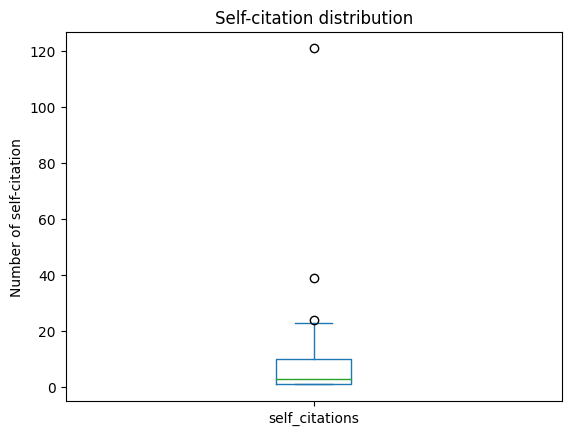

In [29]:
self_citations_df['self_citations'].plot(kind='box')

plt.title("Self-citation distribution")
plt.ylabel("Number of self-citation")
plt.show()

Rimozione dei self-loop

In [30]:
citation_graph.simplify(multiple=True, loops=True, combine_edges='max')
citation_graph.summary()

'IGRAPH DNW- 3333 5356 -- \n+ attr: followers (v), location (v), n_tweets (v), name (v), real_name (v), tweets_time (v), weight (e)'

### Statistiche del grafo

In [31]:
print(f"Nodes: {citation_graph.vcount()} of which {len(users_dict)} ({len(users_dict) / len(citation_graph.vs()) * 100:.2f}%) in dataset and {len(users_not_in_df)} ({len(users_not_in_df) / len(citation_graph.vs()) * 100:.2f}%) only citated")
print(f"Edges: {citation_graph.ecount()}")
print(f'Diameter: {citation_graph.diameter()}')
print(f'Average path length: {citation_graph.average_path_length()}')
print(f'Average degree: {citation_graph.ecount() / citation_graph.vcount()}')
print(f'Average weighted degree: {sum(citation_graph.strength(mode="all", weights="weight")) / citation_graph.vcount()}')
print(f'Density: {citation_graph.density()}')
print(f'Reciprocity: {citation_graph.reciprocity()}')

Nodes: 3333 of which 112 (3.36%) in dataset and 3221 (96.64%) only citated
Edges: 5356
Diameter: 9
Average path length: 3.4584561937083125
Average degree: 1.606960696069607
Average weighted degree: 7.180918091809181
Density: 0.00048228112126938986
Reciprocity: 0.009335324869305451


### Distribuzione del grado dei nodi

#### Grado di ingresso

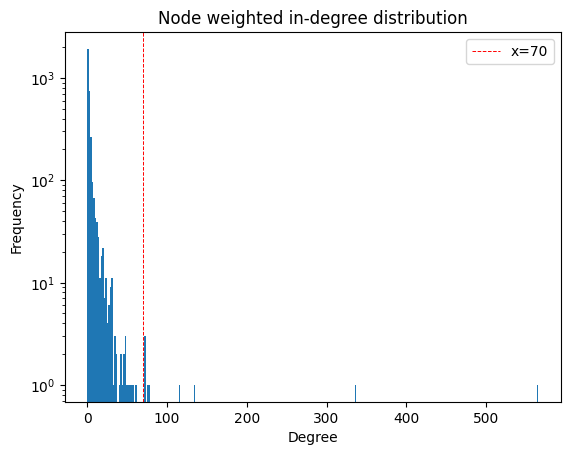

In [32]:
indegree_distr = citation_graph.strength(mode='in', weights='weight', loops=False)
in_threshold = 70

plt.hist(indegree_distr, bins=300, log=True)
plt.axvline(x=in_threshold, color='red', linestyle='--', linewidth=0.7, label=f'x={in_threshold}')

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.title('Node weighted in-degree distribution')
plt.show()

Ricerca degli ***hubs*** (in ingresso)

In [33]:
in_hubs = [v for v in citation_graph.vs() if v.strength(mode='in', weights='weight', loops=False) >= in_threshold]
in_hubs_df = pd.DataFrame([(h['name'], h['followers'], h['n_tweets'], int(h.strength(mode='in', weights='weight', loops=False)), int(h.strength(mode='out', weights='weight', loops=False))) for h in in_hubs], columns=['name', 'followers', 'n_tweets', 'indegree', 'outdegree'])
in_hubs_df = in_hubs_df.sort_values(by="indegree", ascending=False).reset_index(drop=True)

in_hubs_df

,name,followers,n_tweets,indegree,outdegree
0,RamiAlLolah,31796.0,17411.0,565,647
1,Nidalgazaui,4455.0,5703.0,336,89
2,WarReporter1,1659.0,817.0,135,592
3,7layers_,NaN,NaN,116,0
4,ScotsmanInfidel,NaN,NaN,79,0
5,sparksofirhabi3,NaN,NaN,76,0
6,MaghrebiQM,1559.0,343.0,72,96
7,Conflicts,NaN,NaN,72,0
8,DidyouknowVS,NaN,NaN,72,0


Proporzione degli **hubs** sui nodi totali

In [34]:
len(in_hubs_df) / len(citation_graph.vs()) * 100

0.27002700270027

**Grado medio** del grafo (in ingresso)

In [35]:
np.mean(indegree_distr)

3.5904590459045904

**Grado medio** degli utenti presenti nel dataset (in ingresso)

In [36]:
np.mean([d for (i, d) in enumerate(indegree_distr) if citation_graph.vs()[i]['name'] in users_dict])

14.455357142857142

#### Grado in ingresso dei soli **utenti non presenti nel dataset**

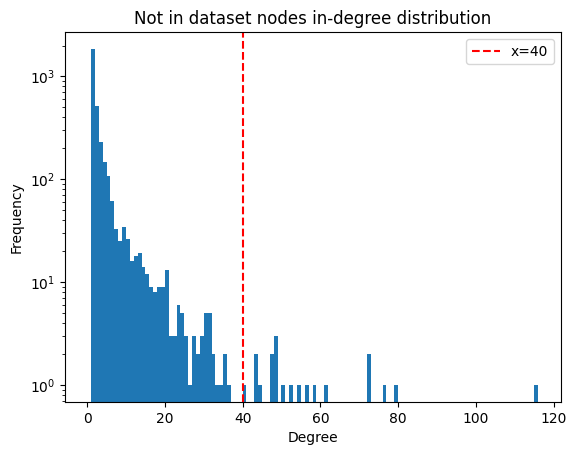

In [37]:
not_users = [v for v in citation_graph.vs() if not v['name'] in users_dict]
not_users_in_threshold = 40

not_users_indegree_dist = [v.strength(mode='in', weights='weight', loops=False) for v in not_users]
plt.hist(not_users_indegree_dist, bins=range(int(max(not_users_indegree_dist)) + 1), log=True)
plt.axvline(x=not_users_in_threshold, color='red', linestyle='--', linewidth=1.5, label=f'x={not_users_in_threshold}')

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.title('Not in dataset nodes in-degree distribution')
plt.show()

In [38]:
not_in_dataset_hubs = [v for v in not_users if v.strength(mode='in', weights='weight', loops=False) >= not_users_in_threshold]
not_in_df_in_hubs_df = pd.DataFrame([(h['name'], int(h.strength(mode='in', weights='weight', loops=False))) for h in not_in_dataset_hubs], columns=['name', 'indegree'])
not_in_df_in_hubs_df = not_in_df_in_hubs_df.sort_values(by="indegree", ascending=False).reset_index(drop=True)

not_in_df_in_hubs_df

,name,indegree
0,7layers_,116
1,ScotsmanInfidel,79
2,sparksofirhabi3,76
3,Conflicts,72
4,DidyouknowVS,72
5,spicylatte123,61
6,Ele7vn,58
7,1_texanna,56
8,sassysassyred,54
9,ShamiRebel,52


**Accounts esistenti** e **non sospesi**:

In [39]:
not_in_df_in_hubs_existant_df = not_in_df_in_hubs_df.iloc[[3, 10, 13, 14, 16, 17, 18], :].reset_index(drop=True)
not_in_df_in_hubs_existant_df

,name,indegree
0,Conflicts,72
1,kasimf,50
2,MousaAlomar,48
3,VivaRevolt,47
4,markito0171,44
5,MiddleEastEye,43
6,AFP,43


Proporzione degli **hubs** sui nodi totali

In [40]:
len(not_in_df_in_hubs_df) / len(not_users) * 100

0.6209251785159888

**Grado medio** degli utenti ***non*** presenti nel dataset (in entrata)

In [41]:
np.mean(not_users_indegree_dist)

3.212666873641726

#### Grado di uscita

Non sono stati considerati gli utenti non presenti nel dataset (in quanto nodi pozzo)

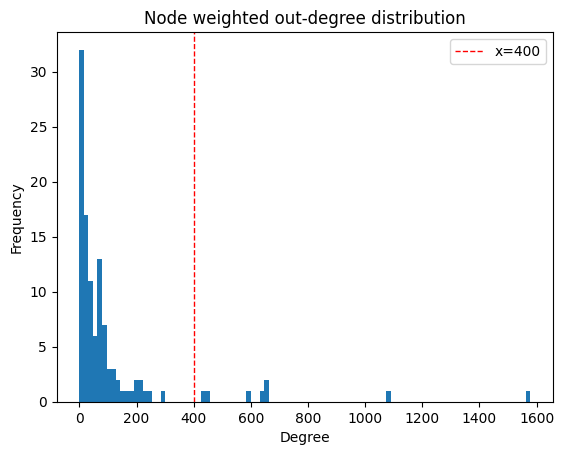

In [42]:
outdegree_distr = citation_graph.strength(mode='out', weights='weight', loops=False)
outdegree_distr = [d for i, d in enumerate(outdegree_distr) if citation_graph.vs()[i]['name'] in users_dict]   # Select only users in dataset
out_threshold = 400

assert len(outdegree_distr) == len(users_dict), "number of nodes not corresponding"

plt.hist(outdegree_distr, bins=100)
plt.axvline(x=out_threshold, color='red', linestyle='--', linewidth=1, label=f'x={out_threshold}')

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.title('Node weighted out-degree distribution')
plt.show()

Ricerca degli ***hubs*** (in uscita)

In [43]:
out_hubs = [v for v in citation_graph.vs() if v.strength(mode='out', weights='weight', loops=False) >= out_threshold]
out_hubs_df = pd.DataFrame([(h['name'], h['followers'], h['n_tweets'], int(h.strength(mode='in', weights='weight', loops=False)), int(h.strength(mode='out', weights='weight', loops=False))) for h in out_hubs], columns=['name', 'followers', 'n_tweets', 'indegree', 'outdegree'])
out_hubs_df = out_hubs_df.sort_values(by="outdegree", ascending=False).reset_index(drop=True)

out_hubs_df

,name,followers,n_tweets,indegree,outdegree
0,Uncle_SamCoco,1572.0,4328,31,1578
1,mobi_ayubi,854.0,7555,2,1078
2,warrnews,7266.0,6735,32,659
3,RamiAlLolah,31796.0,17411,565,647
4,melvynlion,58.0,254,0,638
5,WarReporter1,1659.0,817,135,592
6,MaghrabiArabi,225.0,707,3,450
7,_IshfaqAhmad,1511.0,12981,16,432


**Accounts esistenti** e **non sospesi**:

In [44]:
out_hubs_existance_df = out_hubs_df.iloc[[2], :].reset_index(drop=True)
out_hubs_existance_df

,name,followers,n_tweets,indegree,outdegree
0,warrnews,7266.0,6735,32,659


Proporzione degli **hubs** sui nodi totali

In [45]:
len(out_hubs_df) / len(users_dict) * 100

7.142857142857142

**Grado medio** degli utenti presenti nel dataset (in uscita)

In [46]:
np.mean(outdegree_distr)

106.84821428571429

#### **Correlazione** tra **grado di ingresso** e di **uscita**

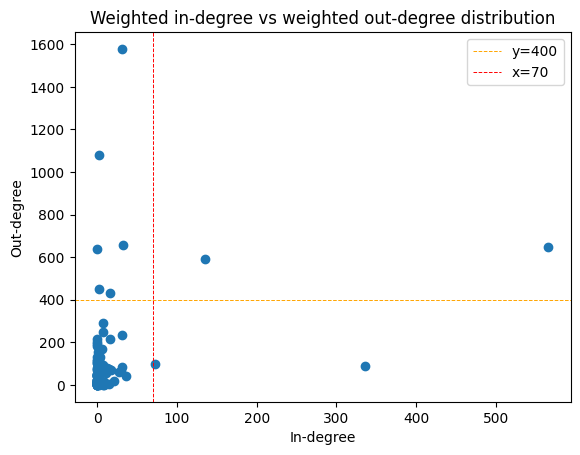

Correlation: 0.2819960318117552


In [47]:
users_indexes = [i for (i, v) in enumerate(citation_graph.vs()) if v['name'] in users_dict]

plt.scatter([indegree_distr[i] for i in users_indexes], outdegree_distr)
plt.axhline(y=out_threshold, color='orange', linestyle='--', linewidth=0.7, label=f'y={out_threshold}')
plt.axvline(x=in_threshold, color='red', linestyle='--', linewidth=0.7, label=f'x={in_threshold}')

plt.xlabel('In-degree')
plt.ylabel('Out-degree')
plt.legend()
plt.title('Weighted in-degree vs weighted out-degree distribution')
plt.show()

print("Correlation:", np.corrcoef([indegree_distr[i] for i in users_indexes], outdegree_distr)[0, 1])

#### Grado totale

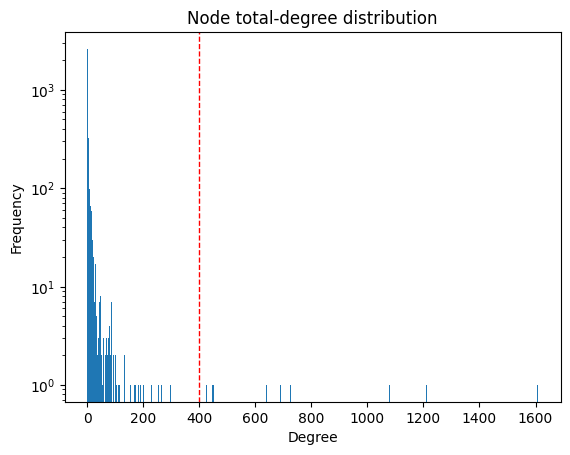

In [48]:
totaldegree_distr = citation_graph.strength(mode='all', weights='weight', loops=False)
all_threshold = 95

plt.hist(totaldegree_distr, bins=500, log=True)
plt.axvline(x=out_threshold, color='red', linestyle='--', linewidth=1)

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.title('Node total-degree distribution')
plt.show()

Ricerca degli ***hubs***

In [49]:
total_hubs = [v for v in citation_graph.vs() if v.strength(mode='all', weights='weight', loops=False) >= all_threshold]
total_hubs_df = pd.DataFrame([(h['name'], h['followers'], h[N_TWEETS_COL_NAME], int(h.strength(mode='in', weights='weight', loops=False)), int(h.strength(mode='out', weights='weight', loops=False)), int(h.strength(mode='all', weights='weight', loops=False))) for h in total_hubs], columns=['name', 'followers', N_TWEETS_COL_NAME, 'indegree', 'outdegree', 'totaldegree'])
total_hubs_df = total_hubs_df.sort_values(by="totaldegree", ascending=False).reset_index(drop=True)

total_hubs_df

,name,followers,n_tweets,indegree,outdegree,totaldegree
0,Uncle_SamCoco,1572.0,4328.0,31,1578,1609
1,RamiAlLolah,31796.0,17411.0,565,647,1212
2,mobi_ayubi,854.0,7555.0,2,1078,1080
3,WarReporter1,1659.0,817.0,135,592,727
4,warrnews,7266.0,6735.0,32,659,691
5,melvynlion,58.0,254.0,0,638,638
6,MaghrabiArabi,225.0,707.0,3,450,453
7,_IshfaqAhmad,1511.0,12981.0,16,432,448
8,Nidalgazaui,4455.0,5703.0,336,89,425
9,AsimAbuMerjem,845.0,396.0,8,289,297


Proporzione degli **hubs** sui nodi totali

In [50]:
len(out_hubs_df) / len(citation_graph.vs()) * 100

0.24002400240024005

**Grado medio** del grafo

In [51]:
np.mean(totaldegree_distr)

7.180918091809181

**Grado medio** degli utenti nel dataset

In [52]:
np.mean([d for (i, d) in enumerate(totaldegree_distr) if citation_graph.vs()[i]['name'] in users_dict])

121.30357142857143

### Componenti (debolmente) connesse

In [53]:
components = citation_graph.connected_components(mode='weak')

max_comp_index = 0
max_comp_size = 0

print("Components weakly connected:", len(components))
print()

for i, comp in enumerate(components):
  if len(comp) > max_comp_size:
    max_comp_size = len(comp)
    max_comp_index = i

  print(f"Component {i}: {len(comp)} nodes")

largest_component = components[max_comp_index]

Components weakly connected: 9

Component 0: 4 nodes
Component 1: 3311 nodes
Component 2: 10 nodes
Component 3: 1 nodes
Component 4: 1 nodes
Component 5: 1 nodes
Component 6: 1 nodes
Component 7: 2 nodes
Component 8: 2 nodes


#### Componente 1

In [54]:
subgraph = citation_graph.induced_subgraph(components[0])
subgraph.summary()

'IGRAPH DNW- 4 3 -- \n+ attr: followers (v), location (v), n_tweets (v), name (v), real_name (v), tweets_time (v), weight (e)'

In [55]:
subgraph_df = pd.DataFrame([(v['name'], v['followers'], v[N_TWEETS_COL_NAME], int(v.strength(mode='in', loops=False, weights='weight')), int(v.strength(mode='out', loops=False, weights='weight'))) for v in subgraph.vs()], columns=['name', 'followers', N_TWEETS_COL_NAME, 'indegree', 'outdegree'])
subgraph_df

,name,followers,n_tweets,indegree,outdegree
0,04_8_1437,71.0,56.0,0,6
1,4_8_1437,NaN,NaN,3,0
2,xxxzzz333,NaN,NaN,2,0
3,uhhgyfergbnj,NaN,NaN,1,0


#### Componente 2

In [56]:
subgraph = citation_graph.induced_subgraph(components[2])
subgraph.summary()

'IGRAPH DNW- 10 9 -- \n+ attr: followers (v), location (v), n_tweets (v), name (v), real_name (v), tweets_time (v), weight (e)'

In [57]:
subgraph_df = pd.DataFrame([(v['name'], v['followers'], v[N_TWEETS_COL_NAME], int(v.strength(mode='in', loops=False, weights='weight')), int(v.strength(mode='out', loops=False, weights='weight'))) for v in subgraph.vs()], columns=['name', 'followers', N_TWEETS_COL_NAME, 'indegree', 'outdegree'])
subgraph_df

,name,followers,n_tweets,indegree,outdegree
0,ALK___226,193.0,42.0,0,9
1,roqaya119,NaN,NaN,1,0
2,Al_Salol_Dooks,NaN,NaN,1,0
3,06kill56,NaN,NaN,1,0
4,bakiyatatamad,NaN,NaN,1,0
5,Jskbin5,NaN,NaN,1,0
6,Daw369Tun,NaN,NaN,1,0
7,Mayyomaar65,NaN,NaN,1,0
8,8550_bardadi,NaN,NaN,1,0
9,___TNT________,NaN,NaN,1,0


#### Componente gigante

In [58]:
largest_comp_subgraph = citation_graph.induced_subgraph(components[max_comp_index])
largest_comp_subgraph.summary()

'IGRAPH DNW- 3311 5342 -- \n+ attr: followers (v), location (v), n_tweets (v), name (v), real_name (v), tweets_time (v), weight (e)'

### Statistiche della componente gigante

In [59]:
n = largest_comp_subgraph.vcount()

in_degrees = largest_comp_subgraph.degree(mode='in')
in_degree_max = max(in_degrees)
out_degrees = largest_comp_subgraph.degree(mode='out')
out_degree_max = max(out_degrees)
all_degrees = [in_degree + out_degree for (in_degree, out_degree) in zip(in_degrees, out_degrees)]
all_degree_max = max(all_degrees)

in_degree_max, out_degree_max, all_degree_max

(50, 626, 640)

In [60]:
in_dataset_nodes = sum([1 if v['name'] in users_dict else 0 for v in largest_comp_subgraph.vs()])
print(f"Nodes: {largest_comp_subgraph.vcount()} of which {in_dataset_nodes} ({in_dataset_nodes / largest_comp_subgraph.vcount() * 100:.2f}%) in dataset and {largest_comp_subgraph.vcount() - in_dataset_nodes} ({(largest_comp_subgraph.vcount() - in_dataset_nodes) / largest_comp_subgraph.vcount() * 100:.2f}%) only citated")
print(f"Edges: {largest_comp_subgraph.ecount()}")
print(f"Freeman's centrality (in): {sum([in_degree_max - degree for degree in in_degrees]) / ((n - 1) * (n - 2))}")
print(f"Freeman's centrality (out): {sum([out_degree_max - degree for degree in out_degrees]) / ((n - 1) * (n - 2))}")
print(f"Freeman's centrality (all): {sum([all_degree_max - degree for degree in all_degrees]) / ((n - 1) * (n - 2) * 2)}")
print(f'Diameter: {largest_comp_subgraph.diameter()}')
print(f'Average path length: {largest_comp_subgraph.average_path_length()}')
print(f'Average degree: {largest_comp_subgraph.ecount() / largest_comp_subgraph.vcount()}')
print(f'Average weighted degree: {sum(largest_comp_subgraph.strength(mode="all", weights="weight")) / largest_comp_subgraph.vcount()}')
print(f'Density: {largest_comp_subgraph.density()}')
print(f'Reciprocity: {largest_comp_subgraph.reciprocity()}')

Nodes: 3311 of which 104 (3.14%) in dataset and 3207 (96.86%) only citated
Edges: 5342
Freeman's centrality (in): 0.014627140664616048
Freeman's centrality (out): 0.18875044623333415
Freeman's centrality (all): 0.09624744014995266
Diameter: 9
Average path length: 3.4586689746839356
Average degree: 1.6134098459679855
Average weighted degree: 7.218363032316521
Density: 0.00048743499878186876
Reciprocity: 0.009359790340696368


In [61]:
def scale_value(val:int):
  if val > 10000:
    return 50
  elif val > 5000:
    return 40
  elif val > 1000:
    return 30
  elif val > 500:
    return 20
  elif val > 100:
    return 10
  else:
    return 5

In [62]:
def nodes_in_dataset(edge_tuple: tuple[int, int]):
  dest = edge_tuple[1]
  if citation_graph.vs[dest]["name"] in users_dict:
    return True

  return False

In [63]:
max_citations = max(largest_comp_subgraph.strength(mode='out', loops=True, weights='weight'))
max_citations

1578.0

#### Plot

In [64]:
visual_style = {}

visual_style["vertex_size"] = [scale_value(node["followers"]) if node["name"] in users_dict else 5 for node in largest_comp_subgraph.vs]
visual_style["vertex_color"] = ["blue" if node["name"] in users_dict else "cyan" for node in largest_comp_subgraph.vs]
#visual_style["vertex_label"] = [node["name"] if (node["name"] in users_dict and node['followers'] >= 3000) else None for node in citation_graph.vs]
#visual_style["vertex_label_size"] = 15
#visual_style["vertex_label_color"] = 'orange'
visual_style["edge_width"] = [edge['weight'] / max_citations * 100 for edge in largest_comp_subgraph.es()]
visual_style["edge_arrow_size"] = 0.3
visual_style["edge_color"] = ["red" if nodes_in_dataset(edge.tuple) else "black" for edge in largest_comp_subgraph.es()]
visual_style["layout"] = 'kk'

#ig.plot(largest_comp_subgraph, **visual_style)

#### Betweenness

Non si considera il peso degli archi

In [65]:
betweenness = largest_comp_subgraph.betweenness(directed=True, weights='weight')

n = len(largest_comp_subgraph.vs())
betweenness = [b / ((n - 1) * (n - 2) / 2) for b in betweenness]     # Normalization

betweenness_df = pd.DataFrame([(v['name'], v['followers'], v[N_TWEETS_COL_NAME], betweenness[i]) for i, v in enumerate(largest_comp_subgraph.vs())], columns=['name', 'followers', N_TWEETS_COL_NAME, 'betweenness'])
betweenness_df = betweenness_df.sort_values(by='betweenness', ascending=False).reset_index(drop=True)

betweenness_df[betweenness_df['betweenness'] > 0]

,name,followers,n_tweets,betweenness
0,Uncle_SamCoco,1572.0,4328.0,1.640675e-02
1,RamiAlLolah,31796.0,17411.0,1.125126e-02
2,NaseemAhmed50,2157.0,5090.0,6.325110e-03
3,MaghrabiArabi,225.0,707.0,4.988469e-03
4,WarReporter1,1659.0,817.0,4.898704e-03
...,...,...,...,...
56,wayff44rer,268.0,20.0,6.391066e-07
57,JohnsonsBot,507.0,33.0,5.478056e-07
58,nvor85j,238.0,133.0,3.652038e-07
59,bintraveller,83.0,29.0,3.652038e-07


#### Closeness

Non si considera il peso degli archi

In [66]:
closeness = largest_comp_subgraph.closeness(mode='all', weights='weight')
closeness_df = pd.DataFrame([(v['name'], v['followers'], v[N_TWEETS_COL_NAME], closeness[i]) for i, v in enumerate(largest_comp_subgraph.vs())], columns=['name', 'followers', N_TWEETS_COL_NAME, 'closeness'])
closeness_df = closeness_df.sort_values(by='closeness', ascending=False).reset_index(drop=True)

closeness_df[closeness_df['closeness'] > 0]

,name,followers,n_tweets,closeness
0,Uncle_SamCoco,1572.0,4328.0,0.310507
1,NaseemAhmed50,2157.0,5090.0,0.294065
2,MaghrabiArabi,225.0,707.0,0.287102
3,warrnews,7266.0,6735.0,0.285640
4,RamiAlLolah,31796.0,17411.0,0.283998
...,...,...,...,...
3306,sassysassyred,NaN,NaN,0.017230
3307,1_texanna,NaN,NaN,0.016656
3308,Ele7vn,NaN,NaN,0.016119
3309,spicylatte123,NaN,NaN,0.015376


#### Eigenvector

In [67]:
eigenvectors_centrality = largest_comp_subgraph.eigenvector_centrality(directed=True, scale=True)
eigenvectors_df = pd.DataFrame([(v['name'], v['followers'], v[N_TWEETS_COL_NAME], eigenvectors_centrality[i]) for i, v in enumerate(largest_comp_subgraph.vs())], columns=['name', 'followers', N_TWEETS_COL_NAME, 'eigenvector'])
eigenvectors_df = eigenvectors_df.sort_values(by='eigenvector', ascending=False).reset_index(drop=True)

eigenvectors_df[eigenvectors_df['eigenvector'] > 0]

,name,followers,n_tweets,eigenvector
0,Nidalgazaui,4455.0,5703.0,1.000000e+00
1,Charles_Lister,NaN,NaN,8.973302e-01
2,RamiAlLolah,31796.0,17411.0,8.924092e-01
3,markito0171,NaN,NaN,8.799232e-01
4,NorthernStork,NaN,NaN,7.922184e-01
...,...,...,...,...
2845,ikrambalekani7,NaN,NaN,7.287438e-20
2846,AbdirahmanBash2,NaN,NaN,4.863084e-20
2847,HudsonLandrock,NaN,NaN,3.270004e-20
2848,ayibeebee,NaN,NaN,3.832972e-21


#### Importanza

In [68]:
importance_df = pd.merge(eigenvectors_df, closeness_df, on=['name', 'followers', N_TWEETS_COL_NAME], how='inner')
importance_df = pd.merge(importance_df, betweenness_df, on=['name', 'followers', N_TWEETS_COL_NAME], how='inner')

importance_df['indegree'] = None
importance_df['outdegree'] = None

for row in tqdm(importance_df.iterrows(), total=len(importance_df)):
   v = largest_comp_subgraph.vs().find(row[1]['name'])
   importance_df.at[row[0], 'indegree'] = int(v.strength(mode='in'))
   importance_df.at[row[0], 'outdegree'] = int(v.strength(mode='out'))

importance_df['totaldegree'] = importance_df['indegree'] + importance_df['outdegree']
importance_df = importance_df[['name', 'followers', N_TWEETS_COL_NAME, 'indegree', 'outdegree', 'totaldegree', 'eigenvector', 'betweenness', 'closeness']]

importance_df.sort_values(by='totaldegree', ascending=False)

100%|██████████| 3311/3311 [00:00<00:00, 7278.66it/s]


,name,followers,n_tweets,indegree,outdegree,totaldegree,eigenvector,betweenness,closeness
32,Uncle_SamCoco,1572.0,4328.0,14,626,640,0.500390,0.016407,0.310507
2,RamiAlLolah,31796.0,17411.0,50,281,331,0.892409,0.011251,0.283998
58,WarReporter1,1659.0,817.0,21,295,316,0.404237,0.004899,0.281463
3030,mobi_ayubi,854.0,7555.0,2,310,312,0.000000,0.000504,0.283828
1549,MaghrabiArabi,225.0,707.0,3,273,276,0.035175,0.004988,0.287102
...,...,...,...,...,...,...,...,...,...
1409,KawlF,NaN,NaN,1,0,1,0.063461,0.000000,0.218064
1410,RidvanMemishi3,NaN,NaN,1,0,1,0.063461,0.000000,0.179035
1411,prince_Sam_11,NaN,NaN,1,0,1,0.063461,0.000000,0.218064
1412,StrangerAkh_,NaN,NaN,1,0,1,0.063461,0.000000,0.218064


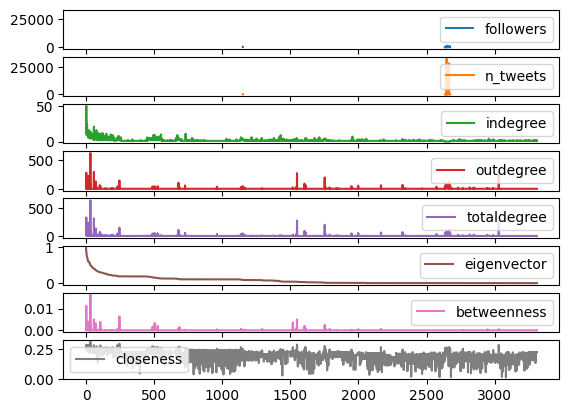

In [69]:
importance_df.plot(kind='line', subplots=True)
plt.show()

##### Correlazione tra le misure di importanza

- **Correlazione di Pearson**: usata se i dati presentano una distribuzione normale;
- **Correlazione di Spearman**: usata se i dati non presentano una distribuzione normale.

Le misure di centralità non presentano una distribuzione normale --> usare **Spearman**


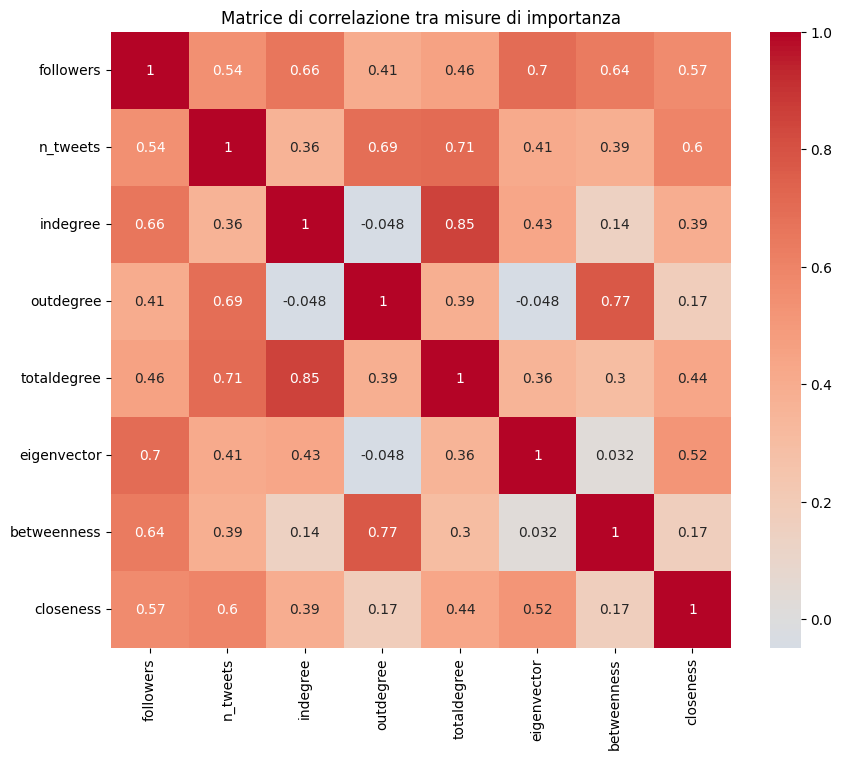

In [70]:
importance_df_corr = importance_df.iloc[:, 1:].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(importance_df_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice di correlazione tra misure di importanza')
plt.show()

#### Assortatività del grafo

In [71]:
largest_comp_subgraph.assortativity(directed=True, types1=largest_comp_subgraph.strength(mode='all', loops='false', weights='weight'))

-0.07848847851639412

## Grafo delle citazioni indotto tra utenti nel dataset

Vengono mantenuti solo i nodi della **componente gigante** che rappresentano **utenti presenti nel dataset** e le loro relazioni

In [72]:
users_citation_graph = citation_graph.induced_subgraph([v for v in components[max_comp_index] if citation_graph.vs()[v]['name'] in users_dict])
users_citation_graph.summary()

'IGRAPH DNW- 104 305 -- \n+ attr: followers (v), location (v), n_tweets (v), name (v), real_name (v), tweets_time (v), weight (e)'

In [73]:
components = users_citation_graph.connected_components(mode='weak')

max_comp_index = 0
max_comp_size = 0

print("Components weakly connected:", len(components))
print()

for i, comp in enumerate(components):
  if len(comp) > max_comp_size:
    max_comp_size = len(comp)
    max_comp_index = i

  print(f"Component {i}: {len(comp)} nodes")

largest_component = components[max_comp_index]

Components weakly connected: 16

Component 0: 88 nodes
Component 1: 2 nodes
Component 2: 1 nodes
Component 3: 1 nodes
Component 4: 1 nodes
Component 5: 1 nodes
Component 6: 1 nodes
Component 7: 1 nodes
Component 8: 1 nodes
Component 9: 1 nodes
Component 10: 1 nodes
Component 11: 1 nodes
Component 12: 1 nodes
Component 13: 1 nodes
Component 14: 1 nodes
Component 15: 1 nodes


In [74]:
users_largest_comp_subgraph = users_citation_graph.induced_subgraph(largest_component)
users_largest_comp_subgraph.summary()

'IGRAPH DNW- 88 303 -- \n+ attr: followers (v), location (v), n_tweets (v), name (v), real_name (v), tweets_time (v), weight (e)'

### Statistiche del grafo

In [75]:
n = users_largest_comp_subgraph.vcount()

in_degrees = users_largest_comp_subgraph.degree(mode='in')
in_degree_max = max(in_degrees)
out_degrees = users_largest_comp_subgraph.degree(mode='out')
out_degree_max = max(out_degrees)
all_degrees = [in_degree + out_degree for (in_degree, out_degree) in zip(in_degrees, out_degrees)]
all_degree_max = max(all_degrees)

in_degree_max, out_degree_max, all_degree_max

(50, 19, 53)

In [76]:
print(f"Nodes: {users_largest_comp_subgraph.vcount()}")
print(f"Edges: {users_largest_comp_subgraph.ecount()}")
print(f"Freeman's centrality (in): {sum([in_degree_max - degree for degree in in_degrees]) / ((n - 1) * (n - 2))}")
print(f"Freeman's centrality (out): {sum([out_degree_max - degree for degree in out_degrees]) / ((n - 1) * (n - 2))}")
print(f"Freeman's centrality (all): {sum([all_degree_max - degree for degree in all_degrees]) / ((n - 1) * (n - 2) * 2)}")
print(f'Diameter: {users_largest_comp_subgraph.diameter()}')
print(f'Average path length: {users_largest_comp_subgraph.average_path_length()}')
print(f'Average degree: {users_largest_comp_subgraph.ecount() / users_largest_comp_subgraph.vcount()}')
print(f'Average weighted degree: {sum(users_largest_comp_subgraph.strength(mode="all", weights="weight")) / users_largest_comp_subgraph.vcount()}')
print(f'Density: {users_largest_comp_subgraph.density()}')
print(f'Reciprocity: {users_largest_comp_subgraph.reciprocity()}')

Nodes: 88
Edges: 303
Freeman's centrality (in): 0.5475808607324245
Freeman's centrality (out): 0.18297246725474473
Freeman's centrality (all): 0.2711841753541834
Diameter: 8
Average path length: 3.1709760827407885
Average degree: 3.4431818181818183
Average weighted degree: 36.70454545454545
Density: 0.039576802507836996
Reciprocity: 0.15841584158415842


### Plot

In [77]:
max_citations = max([e['weight'] for e in users_largest_comp_subgraph.es()])
max_citations

195

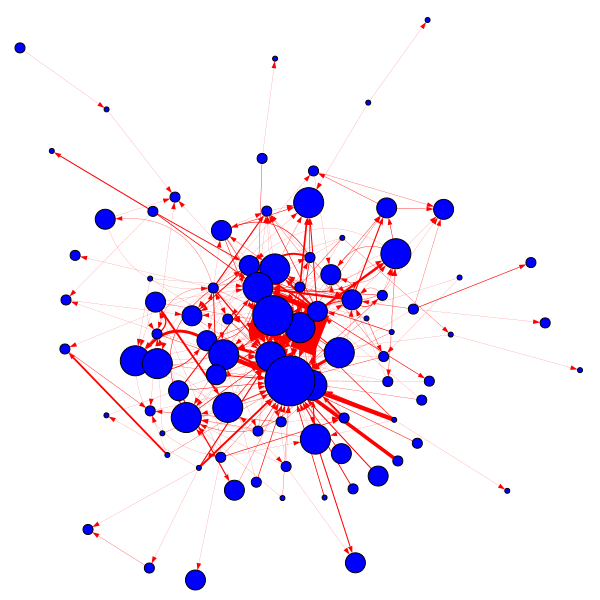

In [78]:
visual_style = {}

visual_style["vertex_size"] = [scale_value(node["followers"]) if node["name"] in users_dict else 5 for node in users_largest_comp_subgraph.vs]
visual_style["vertex_color"] = ["blue" if node["name"] in users_dict else "cyan" for node in users_largest_comp_subgraph.vs]
#visual_style["vertex_label"] = [node["name"] if (node["name"] in users_dict and node['followers'] >= 3000) else None for node in citation_graph.vs]
#visual_style["vertex_label_size"] = 15
visual_style["vertex_label_color"] = 'orange'
visual_style["edge_width"] = [edge['weight'] / max_citations * 25 for edge in users_largest_comp_subgraph.es()]
visual_style["edge_arrow_size"] = 0.5
visual_style["edge_color"] = 'red'
visual_style["layout"] = 'kk'

ig.plot(users_largest_comp_subgraph, **visual_style)

### Distribuzione del grado dei nodi

#### Grado di ingresso

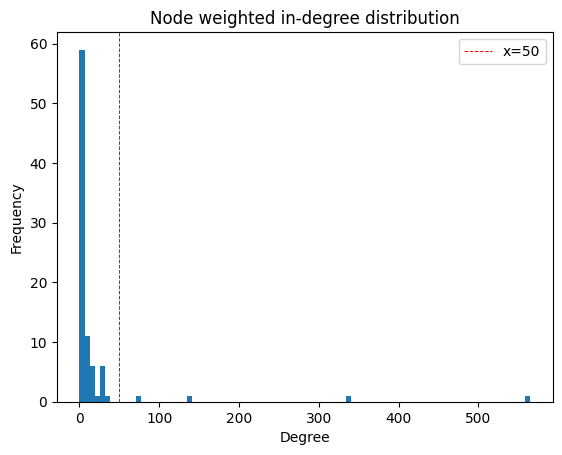

In [79]:
indegree_distr = users_largest_comp_subgraph.strength(mode='in', weights='weight', loops=False)
in_threshold = 50

plt.hist(indegree_distr, bins=88)
plt.axvline(x=in_threshold, color='red', linestyle='--', linewidth=0.7, label=f'x={in_threshold}')

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.title('Node weighted in-degree distribution')
plt.show()

Ricerca degli ***hubs*** (in ingresso)

In [80]:
in_hubs = [v for v in users_largest_comp_subgraph.vs() if v.strength(mode='in', weights='weight', loops=False) >= in_threshold]
in_hubs_df = pd.DataFrame([(h['name'], h['followers'], h[N_TWEETS_COL_NAME], int(h.strength(mode='in', weights='weight', loops=False)), int(h.strength(mode='out', weights='weight', loops=False))) for h in in_hubs], columns=['name', 'followers', N_TWEETS_COL_NAME, 'indegree', 'outdegree'])
in_hubs_df = in_hubs_df.sort_values(by="indegree", ascending=False).reset_index(drop=True)

in_hubs_df

,name,followers,n_tweets,indegree,outdegree
0,RamiAlLolah,31796.0,17411,565,3
1,Nidalgazaui,4455.0,5703,336,3
2,WarReporter1,1659.0,817,135,74
3,MaghrebiQM,1559.0,343,72,4


Proporzione degli **hubs** sui nodi totali

In [81]:
len(in_hubs_df) / len(users_largest_comp_subgraph.vs()) * 100

4.545454545454546

#### Grado di uscita

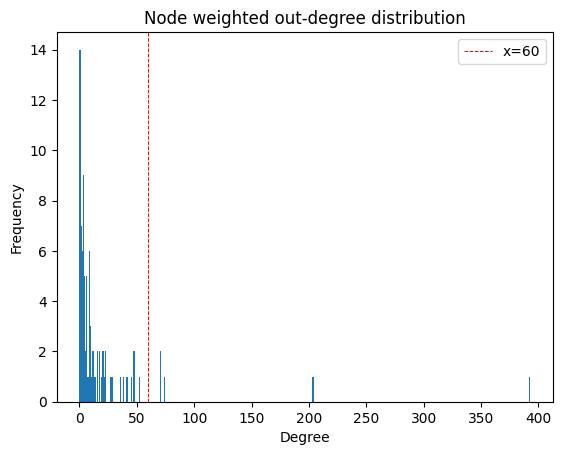

In [82]:
outdegree_distr = users_largest_comp_subgraph.strength(mode='out', weights='weight', loops=False)
out_threshold = 60

plt.hist(outdegree_distr, bins=range(int(max(outdegree_distr) + 1)))
plt.axvline(x=out_threshold, color='red', linestyle='--', linewidth=0.7, label=f'x={out_threshold}')

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.title('Node weighted out-degree distribution')
plt.show()

Ricerca degli ***hubs*** (in uscita)

In [83]:
out_hubs = [v for v in users_largest_comp_subgraph.vs() if v.strength(mode='out', weights='weight', loops=False) >= out_threshold]
out_hubs_df = pd.DataFrame([(h['name'], h['followers'], h[N_TWEETS_COL_NAME], int(h.strength(mode='in', weights='weight', loops=False)), int(h.strength(mode='out', weights='weight', loops=False))) for h in out_hubs], columns=['name', 'followers', N_TWEETS_COL_NAME, 'indegree', 'outdegree'])
out_hubs_df = out_hubs_df.sort_values(by="outdegree", ascending=False).reset_index(drop=True)

out_hubs_df

,name,followers,n_tweets,indegree,outdegree
0,mobi_ayubi,854.0,7555,2,393
1,warrnews,7266.0,6735,32,203
2,WarReporter1,1659.0,817,135,74
3,AsimAbuMerjem,845.0,396,8,70
4,Uncle_SamCoco,1572.0,4328,31,70


In [84]:
len(out_hubs_df) / len(users_largest_comp_subgraph.vs()) * 100

5.681818181818182

#### **Correlazione** tra **grado di ingresso** e di **uscita**

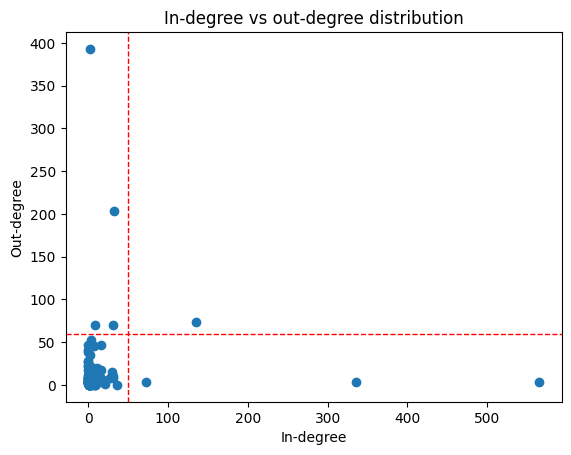

Correlation: -0.008281879594756672


In [85]:
plt.scatter(indegree_distr, outdegree_distr)
plt.axhline(y=out_threshold, color='red', linestyle='--', linewidth=1)
plt.axvline(x=in_threshold, color='red', linestyle='--', linewidth=1)

plt.xlabel('In-degree')
plt.ylabel('Out-degree')
plt.title('In-degree vs out-degree distribution')
plt.show()

print("Correlation:", np.corrcoef(indegree_distr, outdegree_distr)[0, 1])

#### Grado totale

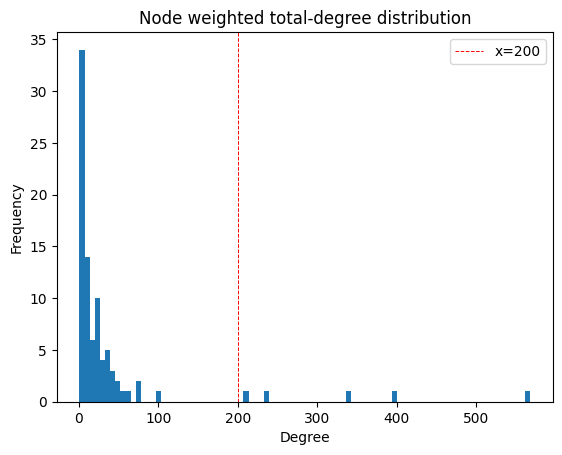

In [86]:
totaldegree_distr = users_largest_comp_subgraph.strength(mode='all', weights='weight', loops=False)
all_threshold = 200

plt.hist(totaldegree_distr, bins=88)
plt.axvline(x=all_threshold, color='red', linestyle='--', linewidth=0.7, label=f'x={all_threshold}')

plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.legend()
plt.title('Node weighted total-degree distribution')
plt.show()

Ricerca degli ***hubs***

In [87]:
total_hubs = [v for v in users_largest_comp_subgraph.vs() if v.strength(mode='all', weights='weight', loops=False) >= all_threshold]
total_hubs_df = pd.DataFrame([(h['name'], h['followers'], h[N_TWEETS_COL_NAME], int(h.strength(mode='in', weights='weight', loops=False)), int(h.strength(mode='out', weights='weight', loops=False)), int(h.strength(mode='all', weights='weight', loops=False))) for h in total_hubs], columns=['name', 'followers', N_TWEETS_COL_NAME, 'indegree', 'outdegree', 'totaldegree'])
total_hubs_df = total_hubs_df.sort_values(by="totaldegree", ascending=False).reset_index(drop=True)

total_hubs_df

,name,followers,n_tweets,indegree,outdegree,totaldegree
0,RamiAlLolah,31796.0,17411,565,3,568
1,mobi_ayubi,854.0,7555,2,393,395
2,Nidalgazaui,4455.0,5703,336,3,339
3,warrnews,7266.0,6735,32,203,235
4,WarReporter1,1659.0,817,135,74,209


Proporzione degli **hubs** sui nodi totali

In [88]:
len(out_hubs_df) / len(citation_graph.vs()) * 100

0.15001500150015

**Grado medio** del grafo

In [89]:
np.mean(totaldegree_distr)

36.70454545454545

### Betweenness

Si considera il peso degli archi

In [90]:
betweenness = users_largest_comp_subgraph.betweenness(directed=True, weights='weight')

n = len(largest_comp_subgraph.vs())
betweenness = [b / ((n - 1) * (n - 2) / 2) for b in betweenness]     # Normalization

betweenness_df = pd.DataFrame([(v['name'], v['followers'], v[N_TWEETS_COL_NAME], betweenness[i]) for i, v in enumerate(users_largest_comp_subgraph.vs())], columns=['name', 'followers', N_TWEETS_COL_NAME, 'betweenness'])
betweenness_df['betweenness'] = betweenness_df['betweenness'] / betweenness_df['betweenness'].max()
betweenness_df = betweenness_df.sort_values(by='betweenness', ascending=False).reset_index(drop=True)

betweenness_df[betweenness_df['betweenness'] > 0]

,name,followers,n_tweets,betweenness
0,Uncle_SamCoco,1572.0,4328,1.000000
1,RamiAlLolah,31796.0,17411,0.572770
2,NaseemAhmed50,2157.0,5090,0.425041
3,MaghrabiArabi,225.0,707,0.390610
4,QassamiMarwan,1593.0,908,0.306590
5,WarReporter1,1659.0,817,0.303486
6,darulhijrateyni,243.0,46,0.242522
7,st3erer,986.0,207,0.233246
8,MilkSheikh2,1184.0,290,0.176552
9,warrnews,7266.0,6735,0.170094


### Closeness

Si considera il peso degli archi

In [91]:
closeness = users_largest_comp_subgraph.closeness(mode='all', normalized=True, weights='weight')
closeness_df = pd.DataFrame([(v['name'], v['followers'], v[N_TWEETS_COL_NAME], closeness[i]) for i, v in enumerate(users_largest_comp_subgraph.vs())], columns=['name', 'followers', N_TWEETS_COL_NAME, 'closeness'])
closeness_df['closeness'] = closeness_df['closeness'] / closeness_df['closeness'].max()
closeness_df = closeness_df.sort_values(by='closeness', ascending=False).reset_index(drop=True)

closeness_df[closeness_df['closeness'] > 0]

,name,followers,n_tweets,closeness
0,RamiAlLolah,31796.0,17411,1.000000
1,Uncle_SamCoco,1572.0,4328,0.977612
2,Nidalgazaui,4455.0,5703,0.970370
3,st3erer,986.0,207,0.925795
4,NaseemAhmed50,2157.0,5090,0.922535
...,...,...,...,...
83,DabiqsweetsMan,89.0,21,0.336761
84,abuhanzalah10,128.0,47,0.303241
85,YazeedDhardaa25,874.0,127,0.275789
86,Mosul_05,27.0,7,0.232889


### Eigenvector

In [92]:
eigenvectors_centrality = users_largest_comp_subgraph.eigenvector_centrality(directed=True, scale=True)
eigenvectors_df = pd.DataFrame([(v['name'], v['followers'], v[N_TWEETS_COL_NAME], eigenvectors_centrality[i]) for i, v in enumerate(users_largest_comp_subgraph.vs())], columns=['name', 'followers', N_TWEETS_COL_NAME, 'eigenvector'])
eigenvectors_df = eigenvectors_df.sort_values(by='eigenvector', ascending=False).reset_index(drop=True)

eigenvectors_df[eigenvectors_df['eigenvector'] > 0]

,name,followers,n_tweets,eigenvector
0,Nidalgazaui,4455.0,5703,1.000000e+00
1,RamiAlLolah,31796.0,17411,8.924092e-01
2,warrnews,7266.0,6735,6.084458e-01
3,__alfresco__,542.0,1060,5.109583e-01
4,Uncle_SamCoco,1572.0,4328,5.003897e-01
...,...,...,...,...
57,pleaoftheummah,93.0,1053,3.809029e-18
58,bintraveller,83.0,29,3.580920e-18
59,wayff44rer,268.0,20,3.100813e-18
60,Mosul_05,27.0,7,2.345127e-18


### Importanza

In [93]:
importance_df = pd.merge(eigenvectors_df, betweenness_df, on=['name', 'followers', N_TWEETS_COL_NAME], how='inner')
importance_df = pd.merge(importance_df, closeness_df, on=['name', 'followers', N_TWEETS_COL_NAME], how='inner')

importance_df['in_strength'] = None
importance_df['out_strength'] = None

for row in importance_df.iterrows():
   v = users_largest_comp_subgraph.vs().find(row[1]['name'])
   importance_df.at[row[0], 'in_strength'] = int(v.strength(mode='in', weights='weight'))
   importance_df.at[row[0], 'out_strength'] = int(v.strength(mode='out', weights='weight'))

importance_df['total_strength'] = importance_df['in_strength'] + importance_df['out_strength']
importance_df = importance_df[['name', 'followers', N_TWEETS_COL_NAME, 'in_strength', 'out_strength', 'total_strength', 'eigenvector', 'betweenness', 'closeness']]

importance_df.sort_values(by='total_strength', ascending=False).reset_index(drop=True)

,name,followers,n_tweets,in_strength,out_strength,total_strength,eigenvector,betweenness,closeness
0,RamiAlLolah,31796.0,17411,565,3,568,8.924092e-01,0.572770,1.000000
1,mobi_ayubi,854.0,7555,2,393,395,8.934498e-18,0.032152,0.784431
2,Nidalgazaui,4455.0,5703,336,3,339,1.000000e+00,0.105550,0.970370
3,warrnews,7266.0,6735,32,203,235,6.084458e-01,0.170094,0.864686
4,WarReporter1,1659.0,817,135,74,209,4.042369e-01,0.303486,0.894198
...,...,...,...,...,...,...,...,...,...
83,CXaafada2,860.0,377,1,0,1,6.128817e-03,0.000000,0.606481
84,MaghrebiQ,320.0,25,1,0,1,7.354486e-03,0.000000,0.684073
85,squadsquaaaaad,57.0,60,1,0,1,5.315603e-18,0.000000,0.415214
86,pleaoftheummah,93.0,1053,1,0,1,3.809029e-18,0.000000,0.531440


#### Correlazione tra le misure di importanza

- **Correlazione di Pearson**: usata se i dati presentano una distribuzione normale;
- **Correlazione di Spearman**: usata se i dati non presentano una distribuzione normale.

Le misure di centralità non presentano una distribuzione normale --> usare **Spearman**


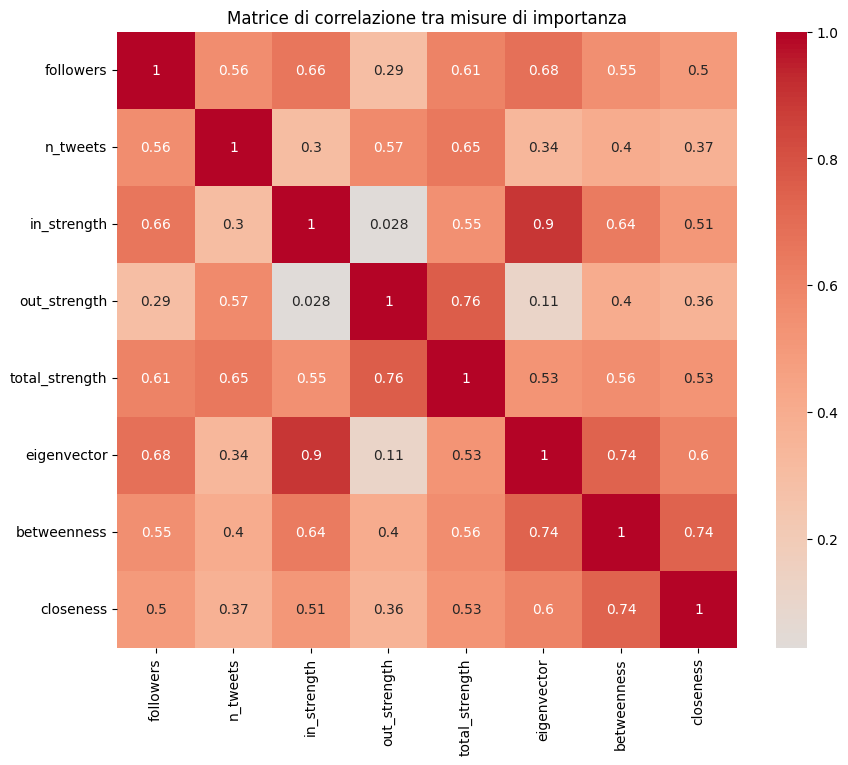

In [94]:
importance_df_corr = importance_df.iloc[:, 1:].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(importance_df_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice di correlazione tra misure di importanza')
plt.show()

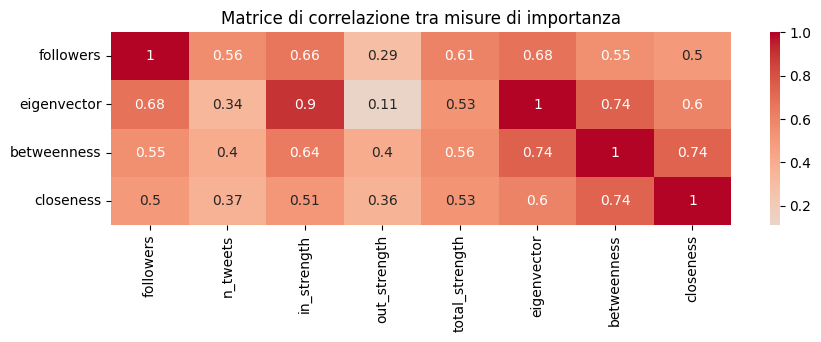

In [95]:
selected_importance_df_corr = importance_df_corr.iloc[[0, 5, 6, 7]]

plt.figure(figsize=(10, 2.5))
sns.heatmap(selected_importance_df_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice di correlazione tra misure di importanza')
plt.show()

#### Calcolo e assegnazione dell'importanza a ogni nodo

L'importanza è ottenuta tramite la **somma pesata normalizzata** delle **misure di centralità** selezionate e **normalizzate** nell'intervallo $[0, 1]$

In [96]:
def compute_importance_coeff(measures:np.array, measures_weight:np.array):
  return np.dot(measures, measures_weight) / np.sum(measures_weight)

In [97]:
measures_weight = np.array([1, 0, 0, 0, 0, 1, 0.5, 1])

importance_df['importance'] = None
max_values = np.array([importance_df[col].max() for col in importance_df.columns[1:-1]])

for index, record in tqdm(importance_df.iterrows(), total=len(importance_df), desc='Computing importance'):
  importance_df.at[index, 'importance'] = compute_importance_coeff(np.array(record[1:-1]) / max_values, measures_weight)

importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
importance_df

Computing importance: 100%|██████████| 88/88 [00:00<00:00, 3676.25it/s]


,name,followers,n_tweets,in_strength,out_strength,total_strength,eigenvector,betweenness,closeness,importance
0,RamiAlLolah,31796.0,17411,565,3,568,8.924092e-01,0.572770,1.000000,0.908227
1,Nidalgazaui,4455.0,5703,336,3,339,1.000000e+00,0.105550,0.970370,0.618074
2,Uncle_SamCoco,1572.0,4328,31,70,101,5.003897e-01,1.000000,0.977612,0.579269
3,warrnews,7266.0,6735,32,203,235,6.084458e-01,0.170094,0.864686,0.510485
4,WarReporter1,1659.0,817,135,74,209,4.042369e-01,0.303486,0.894198,0.429244
...,...,...,...,...,...,...,...,...,...,...
83,DabiqsweetsMan,89.0,21,0,6,6,0.000000e+00,0.000000,0.336761,0.097017
84,abuhanzalah10,128.0,47,0,7,7,0.000000e+00,0.000000,0.303241,0.08779
85,YazeedDhardaa25,874.0,127,0,8,8,0.000000e+00,0.000000,0.275789,0.086651
86,Mosul_05,27.0,7,8,0,8,2.345127e-18,0.000000,0.232889,0.066782


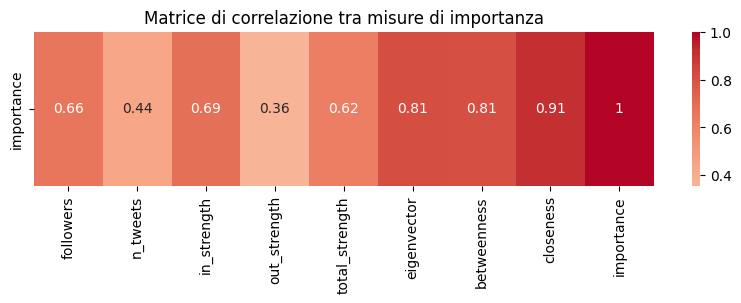

In [98]:
importance_corr = pd.DataFrame(importance_df.iloc[: , 1:].corr(method='spearman').iloc[8]).transpose()

plt.figure(figsize=(10, 2))
sns.heatmap(importance_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Matrice di correlazione tra misure di importanza')
plt.show()

In [99]:
for index, record in importance_df.iterrows():
   v = users_largest_comp_subgraph.vs().find(record['name'])
   v['importance'] = record['importance']

#### Plot

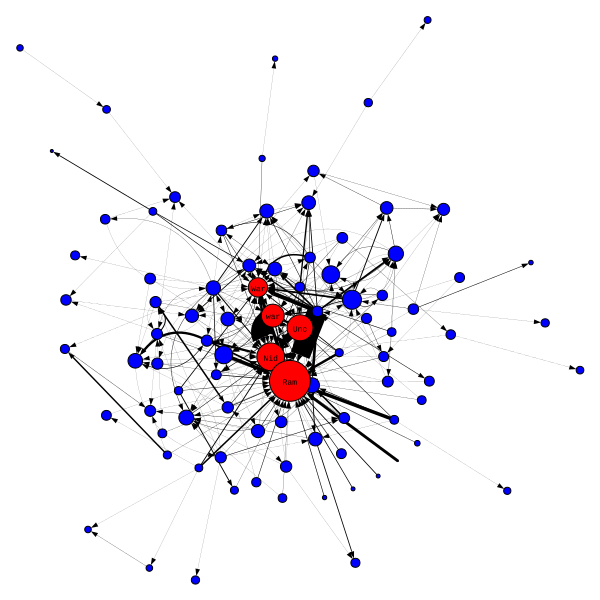

In [100]:
visual_style = {}

visual_style["vertex_size"] = [v["importance"] * 45 for v in users_largest_comp_subgraph.vs()]
visual_style["vertex_color"] = ["red" if v['importance'] >= importance_df.loc[4, 'importance'] else 'blue' for v in users_largest_comp_subgraph.vs()]
visual_style["vertex_label"] = [node["name"][0:3] if node['importance'] >= importance_df.loc[4, 'importance'] else None for node in users_largest_comp_subgraph.vs]
visual_style["vertex_label_size"] = 8
visual_style["vertex_label_color"] = 'black'
visual_style["edge_width"] = [edge['weight'] / max_citations * 20 for edge in users_largest_comp_subgraph.es()]
visual_style["edge_arrow_size"] = 0.5
visual_style["edge_color"] = 'black'
visual_style["layout"] = 'kk'

plot = ig.plot(users_largest_comp_subgraph, **visual_style)
plot.save('users_graph.png')
plot

Ricerca nodo con più citazioni verso RamiAlLolah

In [101]:
incoming_edges = users_largest_comp_subgraph.es.select(_target=users_largest_comp_subgraph.vs().find('RamiAlLolah'))
source_node = max(incoming_edges, key=lambda e: e['weight']).source
users_largest_comp_subgraph.vs()[source_node]['name']

'mobi_ayubi'

### Assortatività del grafo

In [102]:
users_largest_comp_subgraph.assortativity(directed=True, types1=users_largest_comp_subgraph.strength(mode='all', loops='false', weights='weight'))

-0.10421968362162619

### Community detection

#### Clustering

In [103]:
min_n_clusters = 1
max_n_clusters = 30

modularities = []

for i in tqdm(range(min_n_clusters, max_n_clusters + 1)):
  dendogram = users_largest_comp_subgraph.community_edge_betweenness(clusters=i, directed=True)
  modularities.append(dendogram.as_clustering().modularity)

indexes_sorted = [i + 1 for i in np.argsort(modularities)[::-1]]
clusters_modularities = list(zip(indexes_sorted, [modularities[i - 1] for i in indexes_sorted]))
clusters_modularities

100%|██████████| 30/30 [00:00<00:00, 40.94it/s]


[(22, 0.03407073380605388),
 (23, 0.03083575684301111),
 (13, 0.027905760873116952),
 (24, 0.027600779879968233),
 (28, 0.027415612848413606),
 (25, 0.02739382849176006),
 (29, 0.027077955320284407),
 (26, 0.026740297792155338),
 (10, 0.02604319837924387),
 (12, 0.025596619067847375),
 (14, 0.025585726889520613),
 (27, 0.025465912927926392),
 (15, 0.025171824113104327),
 (16, 0.024550969948479898),
 (17, 0.024344018560271755),
 (21, 0.02415885152871722),
 (11, 0.022797329237874246),
 (18, 0.022274504678190546),
 (6, 0.022252720321537044),
 (19, 0.02186060190177437),
 (20, 0.021305100807110414),
 (3, 0.01914844949841525),
 (4, 0.01908309642845478),
 (7, 0.018974174645187268),
 (30, 0.01876722325697922),
 (8, 0.018342428302236112),
 (9, 0.017100719972987337),
 (5, 0.015913472535372362),
 (2, 0.0),
 (1, 0.0)]

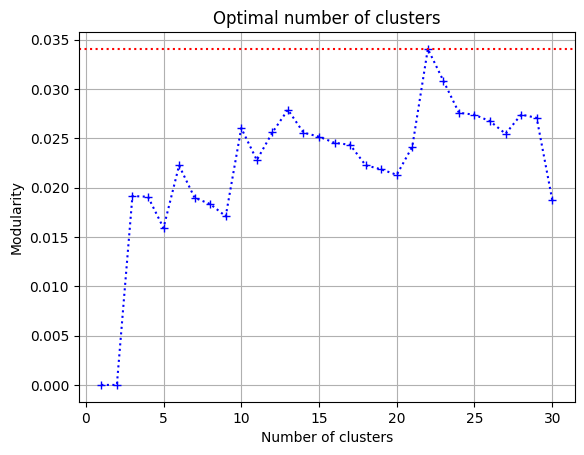

In [104]:
plt.plot(range(min_n_clusters, max_n_clusters + 1), modularities, '+b:')
plt.xlabel('Number of clusters')
plt.ylabel('Modularity')
plt.title('Optimal number of clusters')
plt.axhline(y = max(modularities), color = 'r', linestyle = ':')
plt.grid(True)

In [105]:
clusters = users_largest_comp_subgraph.community_edge_betweenness(clusters=5, directed=True).as_clustering()
for i, cluster in enumerate(clusters):
    print(f"Cluster {i + 1}: {len(cluster)} nodi")

clusters.summary()

Cluster 1: 82 nodi
Cluster 2: 1 nodi
Cluster 3: 1 nodi
Cluster 4: 2 nodi
Cluster 5: 2 nodi


'Clustering with 88 elements and 5 clusters'

#### Plot

In [106]:
visual_style = {}

edge_colors = []
for edge in users_largest_comp_subgraph.es:
    source, target = edge.tuple
    if clusters.membership[source] == clusters.membership[target]:
        edge_colors.append('black')
    else:
        edge_colors.append('red')

visual_style["vertex_size"] = [v["importance"] * 75 for v in users_largest_comp_subgraph.vs()]
#visual_style["edge_width"] = [element for element in users_largest_comp_subgraph.es["weight"]]
visual_style["edge_arrow_size"] = 0.5
visual_style["edge_color"] = edge_colors
visual_style["layout"] = 'graphopt'


#ig.plot(clusters, **visual_style)

## Grafo delle citazioni ad hashtag

Creazione di un grafo bipartito

\begin{align}
Utente → Hashtag
\end{align}

dove ogni nodo possiede un attributo *importanza*:
- per gli *utenti* è il coefficiente calcolato in precedenza;
- per gli *hashtags* è la **somma pesata** del peso degli archi entranti (*numero di citazioni*) per l'importanza dell'utente da cui parte l'arco


In [107]:
hashtags_graph = ig.Graph.Bipartite([], [], directed=True)

hashtags = set()
users = set()

for v in tqdm(users_largest_comp_subgraph.vs(), desc='Populating graph with users'):
  hashtags_graph.add_vertex(type=0, **v.attributes())
  users.add(v['name'])

for user, data in tqdm(users_dict.items(), desc='Populating graph with hashtags'):
  if user in users:
    for hashtag, n_citations in data[HASHTAGS_COL_NAME].items():
        if not hashtag in hashtags:
          hashtags.add(hashtag)
          hashtags_graph.add_vertex(hashtag, type=1)

        hashtags_graph.add_edge(user, hashtag, weight=n_citations)

hashtags_graph.summary()

Populating graph with hashtags: 100%|██████████| 112/112 [00:00<00:00, 187.41it/s]


'IGRAPH DNWT 1955 4497 -- \n+ attr: followers (v), importance (v), location (v), n_tweets (v), name (v), real_name (v), tweets_time (v), type (v), weight (e)'

### Statistiche del grafo

In [108]:
print("Users:", sum([0 if v['type'] else 1 for v in hashtags_graph.vs()]))
print("Hashtags:", len(hashtags))
print(f"Nodes: {hashtags_graph.vcount()}")
print(f"Edges: {hashtags_graph.ecount()}")
print(f'Diameter: {hashtags_graph.diameter()}')
print(f'Average path length: {hashtags_graph.average_path_length()}')
print(f'Average weighted degree: {sum([e["weight"] for e in hashtags_graph.es()]) / len([v for v in hashtags_graph.vs() if not v["type"]])}')
print(f'Density: {hashtags_graph.density()}')
print(f'Reciprocity: {hashtags_graph.reciprocity()}')

assert users_largest_comp_subgraph.vcount() + len(hashtags) == len(hashtags_graph.vs), "Number of nodes not corresponding"
assert hashtags_graph.ecount() == sum([len(users_dict[user][HASHTAGS_COL_NAME]) if user in users else 0 for user in users_dict]), "Number of citations not corresponding"

Users: 88
Hashtags: 1867
Nodes: 1955
Edges: 4497
Diameter: 1
Average path length: 1.0
Average weighted degree: 170.11363636363637
Density: 0.0011772035590970845
Reciprocity: 0.0


Componenti (debolmente) connesse

In [109]:
components = hashtags_graph.connected_components(mode='weak')

max_comp_index = 0
max_comp_size = 0

print("Components weakly connected:", len(components))

for i, comp in enumerate(components):
  if len(comp) > max_comp_size:
    max_comp_size = len(comp)
    max_comp_index = i

  print(f"\tComponent {i+1}: {len(comp)} nodes")

largest_component = components[max_comp_index]

Components weakly connected: 4
	Component 1: 1952 nodes
	Component 2: 1 nodes
	Component 3: 1 nodes
	Component 4: 1 nodes


In [110]:
largest_comp_subgraph = hashtags_graph.induced_subgraph(largest_component)
largest_comp_subgraph.summary()

'IGRAPH DNWT 1952 4497 -- \n+ attr: followers (v), importance (v), location (v), n_tweets (v), name (v), real_name (v), tweets_time (v), type (v), weight (e)'

### Assegnazione del sentiment a ogni hashtag

In [111]:
entity_sentiment_df

,entity,sentiment
0,muthanna,0.958244
1,suwayda,0.946444
2,the crusader belgiumhttps://t,0.925306
3,one or 2 years,0.898593
4,ladh,0.898593
...,...,...
7661,rt mintpressnews,-0.960124
7662,rt asgharbukhari,-0.960124
7663,imrbhachu,-0.960124
7664,"nwo!""is",-0.978279


In [112]:
hashtags_with_no_sentiment = []

entity_sentiment_dict = entity_sentiment_df.set_index('entity')['sentiment'].to_dict()
for v in largest_comp_subgraph.vs():
  if v['type']:
    if v['name'] in entity_sentiment_dict:
      v['sentiment'] = entity_sentiment_dict[v['name']]
    else:
      v['sentiment'] = 0
      hashtags_with_no_sentiment.append(v['name'])

largest_comp_subgraph.summary()

'IGRAPH DNWT 1952 4497 -- \n+ attr: followers (v), importance (v), location (v), n_tweets (v), name (v), real_name (v), sentiment (v), tweets_time (v), type (v), weight (e)'

In [113]:
len(hashtags_with_no_sentiment)

1371

### Calcolo e assegnazione dell'importanza a ogni hashtag

\begin{align}
Importance(v) = ∑_{e = u → v} w(e) × Importance(u) \\
\end{align}

In [114]:
max_importance = 0

for v in tqdm(largest_comp_subgraph.vs(), desc='Computing hashtags importance'):
  if v['type']:
    v['importance'] = sum([u['importance'] * largest_comp_subgraph.es()[largest_comp_subgraph.get_eid(u, v)]['weight'] for u in v.predecessors()])
    if v['importance'] > max_importance:
      max_importance = v['importance']

largest_comp_subgraph.summary()

Computing hashtags importance: 100%|██████████| 1952/1952 [00:00<00:00, 63251.56it/s]


'IGRAPH DNWT 1952 4497 -- \n+ attr: followers (v), importance (v), location (v), n_tweets (v), name (v), real_name (v), sentiment (v), tweets_time (v), type (v), weight (e)'

In [115]:
for v in tqdm(largest_comp_subgraph.vs(), desc='Normalizing hashtags importance'):
  if v['type']:
    v['importance'] /= max_importance

Normalizing hashtags importance: 100%|██████████| 1952/1952 [00:00<00:00, 242420.91it/s]


In [116]:
with open('hashtags_graph.pkl', 'wb') as f:
  pickle.dump(largest_comp_subgraph, f)

### Classifica degli hashtags più importanti

In [117]:
hashtags_importance_pairs = [(v['name'], int(v.strength(mode='in', weights='weight')), v['sentiment'], v['importance']) for v in largest_comp_subgraph.vs() if v['type']]
hashtags_importance_df = pd.DataFrame(hashtags_importance_pairs, columns=['name', 'citations', 'sentiment', 'importance']).sort_values(by='importance', ascending=False).reset_index(drop=True)
hashtags_importance_df.iloc[:20, :]

,name,citations,sentiment,importance
0,syria,1402,-0.163610,1.000000
1,isis,1553,-0.205410,0.955278
2,iraq,633,-0.176156,0.410634
3,is,643,-0.109602,0.261743
4,aleppo,419,-0.226908,0.237580
5,usa,272,-0.164008,0.209690
6,turkey,248,-0.146222,0.195603
7,breakingnews,252,-0.207087,0.194330
8,russia,277,-0.126633,0.179010
9,assad,247,-0.182035,0.155657


In [118]:
def scale_value(x):
  if x > 0.9:
    return 80
  elif x > 0.5:
    return 40
  elif x > 0.2:
    return 20
  elif x > 0.1:
    return 10
  else:
    return 5

### Plot

In [119]:
visual_style = {}

visual_style["vertex_size"] = [scale_value(node["importance"]) for node in largest_comp_subgraph.vs()]
visual_style["vertex_color"] = ["red" if node["type"] else 'blue' for node in largest_comp_subgraph.vs()]
#visual_style["vertex_label"] = [node["name"] if (node["name"] in users_dict and node['followers'] >= 3000) else None for node in citation_graph.vs]
#visual_style["vertex_label_size"] = 15
#visual_style["vertex_label_color"] = 'orange'
visual_style["edge_width"] = [edge['weight'] / max_citations * 20 for edge in largest_comp_subgraph.es()]
visual_style["edge_arrow_size"] = 0.3
visual_style["edge_color"] = 'black'
visual_style["layout"] = 'bipartite'

#ig.plot(largest_comp_subgraph, **visual_style)

## Grafo delle citazioni ad entità

Creazione di un grafo bipartito

\begin{align}
Utente → Entità
\end{align}

dove ogni nodo possiede un attributo *importanza*:
- per gli *utenti* è il coefficiente calcolato in precedenza;
- per le *entità* è la **somma pesata** del peso degli archi entranti (*numero di citazioni*) per l'importanza dell'utente da cui parte l'arco


In [120]:
user_as_entity = lambda x : x + " user"

In [121]:
entities_to_delete = set()

for user, data in tqdm(users_dict.items(), desc='Renaming entities which are users'):
    for entity, n_citations in data[ENTITIES_COL_NAME].items():
        if entity in users:
            data[user_as_entity(entity)] = n_citations
            entities_to_delete.add(entity)

for user, data in tqdm(users_dict.items(), desc='Cleaning duplicated entities'):
    for entity_to_delete in entities_to_delete:
        if entity_to_delete in data:
            del data[entity_to_delete]

Cleaning duplicated entities: 100%|██████████| 112/112 [00:00<00:00, 441091.12it/s]


In [122]:
entities_graph = ig.Graph.Bipartite([], [], directed=True)

entities = set()
users = set()

for v in tqdm(users_largest_comp_subgraph.vs(), desc='Populating graph with users'):
    entities_graph.add_vertex(type=0, **v.attributes())
    users.add(v['name'])

for user, data in tqdm(users_dict.items(), desc='Populating graph with entities'):
    if user in users:
        for entity, n_citations in data[ENTITIES_COL_NAME].items():
            if not entity in entities:
                entities.add(entity)
                entities_graph.add_vertex(entity, type=1, category=entity_tweet_dict[entity])

            entities_graph.add_edge(user, entity, weight=n_citations)

entities_graph.summary()

Populating graph with entities: 100%|██████████| 112/112 [00:12<00:00,  8.84it/s]


'IGRAPH DNWT 7315 19598 -- \n+ attr: category (v), followers (v), importance (v), location (v), n_tweets (v), name (v), real_name (v), tweets_time (v), type (v), weight (e)'

### Statistiche del grafo

In [123]:
print("Users:", sum([0 if v['type'] else 1 for v in entities_graph.vs()]))
print("Entities:", len(entities))
print(f"Nodes: {entities_graph.vcount()}")
print(f"Edges: {entities_graph.ecount()}")
print(f'Diameter: {entities_graph.diameter()}')
print(f'Average path length: {entities_graph.average_path_length()}')
print(f'Average weighted degree: {sum([e["weight"] for e in entities_graph.es()]) / len([v for v in entities_graph.vs() if not v["type"]])}')
print(f'Density: {entities_graph.density()}')
print(f'Reciprocity: {entities_graph.reciprocity()}')

assert users_largest_comp_subgraph.vcount() + len(entities) == len(entities_graph.vs), "Number of nodes not corresponding"

Users: 88
Entities: 7227
Nodes: 7315
Edges: 19598
Diameter: 1
Average path length: 1.0
Average weighted degree: 520.5
Density: 0.00036630467958994364
Reciprocity: 0.0


Componenti (debolmente) connesse

In [124]:
components = entities_graph.connected_components(mode='weak')

max_comp_index = 0
max_comp_size = 0

print("Components weakly connected:", len(components))

for i, comp in enumerate(components):
  if len(comp) > max_comp_size:
    max_comp_size = len(comp)
    max_comp_index = i

  print(f"\tComponent {i+1}: {len(comp)} nodes")

largest_component = components[max_comp_index]

Components weakly connected: 2
	Component 1: 7314 nodes
	Component 2: 1 nodes


In [125]:
largest_comp_subgraph = entities_graph.induced_subgraph(largest_component)
largest_comp_subgraph.summary()

'IGRAPH DNWT 7314 19598 -- \n+ attr: category (v), followers (v), importance (v), location (v), n_tweets (v), name (v), real_name (v), tweets_time (v), type (v), weight (e)'

### Assegnazione del sentiment a ogni entità

In [126]:
entity_sentiment_df

,entity,sentiment
0,muthanna,0.958244
1,suwayda,0.946444
2,the crusader belgiumhttps://t,0.925306
3,one or 2 years,0.898593
4,ladh,0.898593
...,...,...
7661,rt mintpressnews,-0.960124
7662,rt asgharbukhari,-0.960124
7663,imrbhachu,-0.960124
7664,"nwo!""is",-0.978279


In [127]:
entities_with_no_sentiment = []

entity_sentiment_dict = entity_sentiment_df.set_index('entity')['sentiment'].to_dict()
for v in largest_comp_subgraph.vs():
  if v['type']:
    if v['name'] in entity_sentiment_dict:
      v['sentiment'] = entity_sentiment_dict[v['name']]
    else:
      v['sentiment'] = 0
      entities_with_no_sentiment.append(v['name'])

largest_comp_subgraph.summary()

'IGRAPH DNWT 7314 19598 -- \n+ attr: category (v), followers (v), importance (v), location (v), n_tweets (v), name (v), real_name (v), sentiment (v), tweets_time (v), type (v), weight (e)'

In [128]:
entities_with_no_sentiment

[]

### Calcolo e assegnazione dell'importanza a ogni entità

\begin{align}
Importance(v) = ∑_{e = u → v} w(e) × Importance(u) \\
\end{align}

In [129]:
max_importance = 0

for v in tqdm(largest_comp_subgraph.vs(), desc='Computing entities importance'):
  if v['type']:
    v['importance'] = sum([u['importance'] * largest_comp_subgraph.es()[largest_comp_subgraph.get_eid(u, v)]['weight'] for u in v.predecessors()])
    if v['importance'] > max_importance:
      max_importance = v['importance']

largest_comp_subgraph.summary()

Computing entities importance: 100%|██████████| 7314/7314 [00:00<00:00, 49702.20it/s]


'IGRAPH DNWT 7314 19598 -- \n+ attr: category (v), followers (v), importance (v), location (v), n_tweets (v), name (v), real_name (v), sentiment (v), tweets_time (v), type (v), weight (e)'

In [130]:
for v in tqdm(largest_comp_subgraph.vs(), desc='Normalizing entities importance'):
  if v['type']:
    v['importance'] /= max_importance

Normalizing entities importance: 100%|██████████| 7314/7314 [00:00<00:00, 349389.98it/s]


In [131]:
with open('entity_graph.pkl', 'wb') as f:
  pickle.dump(largest_comp_subgraph, f)

### Classifica delle entità più importanti

In [132]:
entity_importance_tuple = [(v['name'], v['category'], int(v.strength(mode='in', loops=False, weights='weight')), v['sentiment'], v['importance']) for v in largest_comp_subgraph.vs() if v['type']]
entity_importance_df = pd.DataFrame(entity_importance_tuple, columns=['name', 'category', 'citations', 'sentiment', 'importance']).sort_values(by='importance', ascending=False).reset_index(drop=True)
entity_importance_df.iloc[:, :]

,name,category,citations,sentiment,importance
0,isis,ORG,1987,-0.205410,1.000000
1,syria,GPE,1457,-0.163610,0.867576
2,rt,GPE,1465,-0.125751,0.475710
3,assad,PERSON,741,-0.182035,0.367882
4,iraq,GPE,601,-0.176156,0.308385
...,...,...,...,...,...
7221,oil/petrochemical,ORG,1,-0.545160,0.000032
7222,showail,PERSON,1,0.067821,0.000032
7223,the path of salvation,WORK_OF_ART,1,0.383388,0.000032
7224,assad kill adults,PERSON,1,0.099138,0.000032


### Classifica delle entità più polarizzanti

In [133]:
n_entities = int(len(entity_importance_df) * 0.7)

#### Sentiment più alto

In [134]:
entity_importance_df.iloc[:n_entities, :].sort_values(by='sentiment', ascending=False)

,name,category,citations,sentiment,importance
4701,muthanna,PERSON,1,0.958244,0.000362
1893,suwayda,GPE,2,0.946444,0.001164
4781,a must read 👀,WORK_OF_ART,1,0.898593,0.000350
4833,one or 2 years,DATE,1,0.898593,0.000344
4834,wapens,PRODUCT,1,0.898593,0.000344
...,...,...,...,...,...
4954,caesar,PERSON,1,-0.907346,0.000330
4938,khaled hourani,PERSON,1,-0.907346,0.000330
3049,course!he,ORG,1,-0.930493,0.000623
4863,stevoiraq burn in hell shia pigs,WORK_OF_ART,1,-0.960124,0.000344


#### Sentiment più basso

In [135]:
entity_importance_df.iloc[:n_entities, :].sort_values(by='sentiment', ascending=True)

,name,category,citations,sentiment,importance
4276,rt mintpressnews,ORG,1,-0.960124,0.000461
4863,stevoiraq burn in hell shia pigs,WORK_OF_ART,1,-0.960124,0.000344
3049,course!he,ORG,1,-0.930493,0.000623
4938,khaled hourani,PERSON,1,-0.907346,0.000330
4954,caesar,PERSON,1,-0.907346,0.000330
...,...,...,...,...,...
4834,wapens,PRODUCT,1,0.898593,0.000344
4781,a must read 👀,WORK_OF_ART,1,0.898593,0.000350
4833,one or 2 years,DATE,1,0.898593,0.000344
1893,suwayda,GPE,2,0.946444,0.001164


#### Polarità più alta

In [136]:
entity_importance_df.iloc[:n_entities, :].sort_values(by='sentiment', key=lambda x : abs(x), ascending=False)

,name,category,citations,sentiment,importance
4276,rt mintpressnews,ORG,1,-0.960124,0.000461
4863,stevoiraq burn in hell shia pigs,WORK_OF_ART,1,-0.960124,0.000344
4701,muthanna,PERSON,1,0.958244,0.000362
1893,suwayda,GPE,2,0.946444,0.001164
3049,course!he,ORG,1,-0.930493,0.000623
...,...,...,...,...,...
4018,southern nineveh,LOC,2,0.000000,0.000494
2784,4b,CARDINAL,2,0.000000,0.000700
2788,5b,CARDINAL,2,0.000000,0.000700
4014,saqrqaa3d saeed_alhalabi7,PERSON,2,0.000000,0.000496


### Plot

In [137]:
def scale_value(x):
  if x > 0.9:
    return 80
  elif x > 0.5:
    return 40
  elif x > 0.2:
    return 20
  elif x > 0.1:
    return 10
  else:
    return 5

In [138]:
visual_style = {}

visual_style["vertex_size"] = [scale_value(node["importance"]) for node in largest_comp_subgraph.vs()]
visual_style["vertex_color"] = ["red" if node["type"] else 'blue' for node in largest_comp_subgraph.vs()]
#visual_style["vertex_label"] = [node["name"] if (node["name"] in users_dict and node['followers'] >= 3000) else None for node in citation_graph.vs]
#visual_style["vertex_label_size"] = 15
#visual_style["vertex_label_color"] = 'orange'
visual_style["edge_width"] = [edge['weight'] / max_citations * 20 for edge in largest_comp_subgraph.es()]
visual_style["edge_arrow_size"] = 0.3
visual_style["edge_color"] = 'black'
visual_style["layout"] = 'bipartite'

#ig.plot(largest_comp_subgraph, **visual_style)

### Correlazione tra ranking delle entità e ranking degli hashtags

Entità che sono anche hashtags:

In [139]:
entities_lower = set([e.lower() for e in entities])
entities_hashtags = entities_lower & hashtags
len(entities_hashtags)

491

In [140]:
entity_importance_df_no_sent = entity_importance_df.loc[:, ['name', 'category', 'citations', 'importance']]
entity_importance_df_no_sent.columns = ['name', 'category', 'citations_as_entity', 'importance_as_entity']

hashtags_importance_df_no_sent = hashtags_importance_df.loc[:, ['name', 'citations', 'importance']]
hashtags_importance_df_no_sent.columns = ['name', 'citations_as_hashtag', 'importance_as_hashtag']
hashtags_importance_df_no_sent['name'] = hashtags_importance_df_no_sent['name'].apply(lambda x : x.lower())

entities_hashtags_df = entity_importance_df_no_sent.merge(hashtags_importance_df_no_sent, on='name', how='inner')
entities_hashtags_df = entities_hashtags_df[['name', 'category', 'citations_as_hashtag', 'citations_as_entity', 'importance_as_hashtag', 'importance_as_entity']]

entities_hashtags_df.head(20)

,name,category,citations_as_hashtag,citations_as_entity,importance_as_hashtag,importance_as_entity
0,isis,ORG,1553,1987,0.955278,1.000000
1,syria,GPE,1402,1457,1.000000,0.867576
2,rt,GPE,1,1465,0.000259,0.475710
3,assad,PERSON,247,741,0.155657,0.367882
4,iraq,GPE,633,601,0.410634,0.308385
5,aleppo,GPE,419,530,0.237580,0.255128
6,us,GPE,123,667,0.048949,0.247605
7,turkey,GPE,248,376,0.195603,0.238423
8,usa,ORG,272,265,0.209690,0.164813
9,syrian,NORP,57,367,0.034403,0.160211


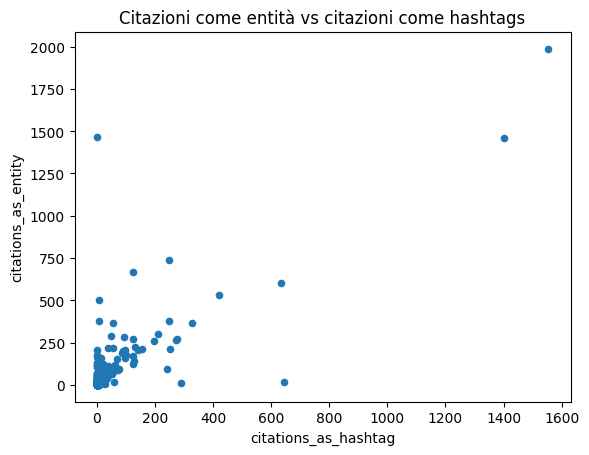

In [141]:
entities_hashtags_df.loc[:, ['citations_as_hashtag', 'citations_as_entity']].plot(kind='scatter', x='citations_as_hashtag', y='citations_as_entity')

plt.title("Citazioni come entità vs citazioni come hashtags")
plt.show()

In [142]:
citations_corr = entities_hashtags_df.loc[:, ['citations_as_hashtag', 'citations_as_entity']].corr(method='pearson')
citations_corr

,citations_as_hashtag,citations_as_entity
citations_as_hashtag,1.000000,0.789774
citations_as_entity,0.789774,1.000000


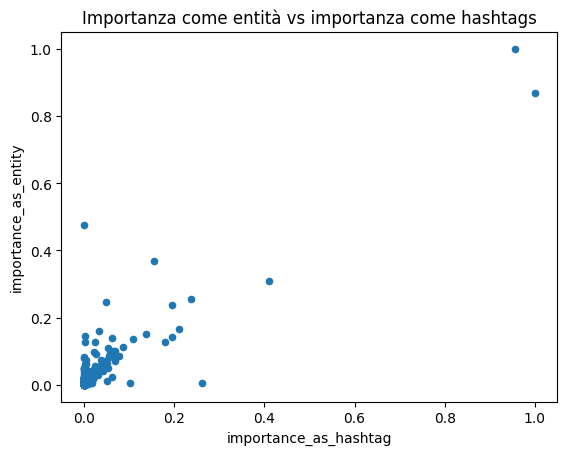

In [143]:
entities_hashtags_df.loc[:, ['importance_as_hashtag', 'importance_as_entity']].plot(kind='scatter', x='importance_as_hashtag', y='importance_as_entity')

plt.title("Importanza come entità vs importanza come hashtags")
plt.show()

In [144]:
importance_corr = entities_hashtags_df.loc[:, ['importance_as_hashtag', 'importance_as_entity']].corr(method='pearson')
importance_corr

,importance_as_hashtag,importance_as_entity
importance_as_hashtag,1.000000,0.890298
importance_as_entity,0.890298,1.000000


### Correlazione tra importanza e polarità

In [145]:
entity_abs_sentiment_df = entity_sentiment_df.copy()
entity_abs_sentiment_df.columns = ['name', 'polarity']
entity_abs_sentiment_df['polarity'] = entity_sentiment_df['sentiment'].apply(lambda x : abs(x))
entity_abs_sentiment_df = entity_abs_sentiment_df.sort_values(by='polarity', ascending=False).reset_index(drop=True)

entity_abs_sentiment_df

,name,polarity
0,jsiwat your jihad,1.000000
1,"nwo!""is",0.978279
2,palace,0.960124
3,imrbhachu,0.960124
4,rt asgharbukhari,0.960124
...,...,...
7661,allahu minna wa minkum,0.000000
7662,wilayah sulu/,0.000000
7663,sulu,0.000000
7664,ft,0.000000


Correlazione tra tutte le entità

In [146]:
entity_importance_polarity_df = entity_importance_df.copy()
entity_importance_polarity_df.columns = ['name', 'category', 'citations', 'polarity', 'importance']
entity_importance_polarity_df['polarity'] = entity_importance_polarity_df['polarity'].apply(lambda x : abs(x))
entity_importance_polarity_df

,name,category,citations,polarity,importance
0,isis,ORG,1987,0.205410,1.000000
1,syria,GPE,1457,0.163610,0.867576
2,rt,GPE,1465,0.125751,0.475710
3,assad,PERSON,741,0.182035,0.367882
4,iraq,GPE,601,0.176156,0.308385
...,...,...,...,...,...
7221,oil/petrochemical,ORG,1,0.545160,0.000032
7222,showail,PERSON,1,0.067821,0.000032
7223,the path of salvation,WORK_OF_ART,1,0.383388,0.000032
7224,assad kill adults,PERSON,1,0.099138,0.000032


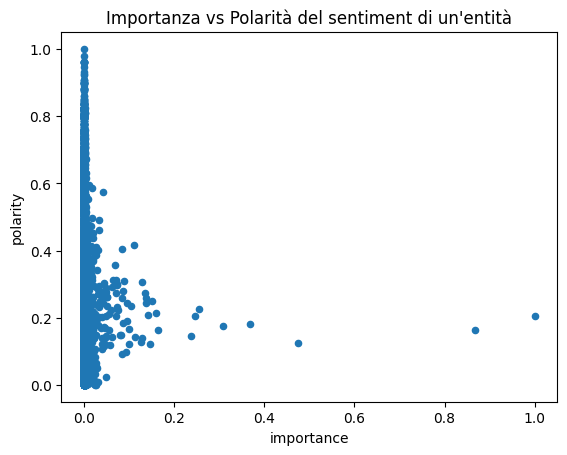

In [147]:
entity_importance_polarity_df.loc[:, ['importance', 'polarity']].plot(kind='scatter', x='importance', y='polarity')

plt.title("Importanza vs Polarità del sentiment di un'entità")
plt.show()

In [148]:
importance_polarity_corr = entity_importance_polarity_df.loc[:, ['importance', 'polarity']].corr(method='pearson')
importance_polarity_corr

,importance,polarity
importance,1.000000,-0.017045
polarity,-0.017045,1.000000


Correlazione tra le entità più importanti

In [149]:
n_entities = int(len(entity_importance_df) * 0.7)

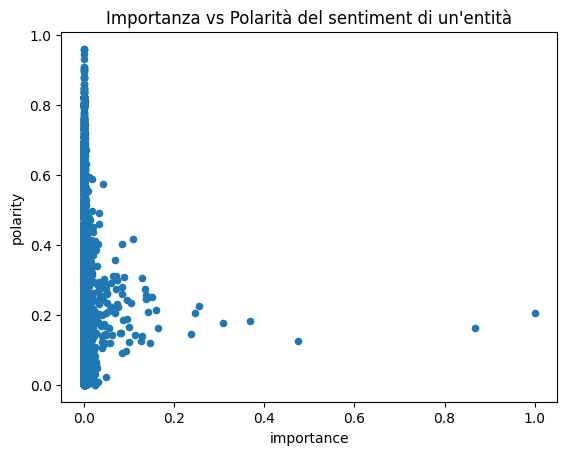

In [150]:
entity_importance_polarity_df.loc[:n_entities, ['importance', 'polarity']].plot(kind='scatter', x='importance', y='polarity')

plt.title("Importanza vs Polarità del sentiment di un'entità")
plt.show()

In [151]:
importance_polarity_corr = entity_importance_polarity_df.loc[:n_entities, ['importance', 'polarity']].corr(method='pearson')
importance_polarity_corr

,importance,polarity
importance,1.000000,-0.018556
polarity,-0.018556,1.000000
